### Moving onto feature engineering. Our goal is to Predict which products a user will reorder in their next purchase.

### Instacart wants to improve product recommendation in their shopping cart reordering system by predicting the next set of items each customer will buy 

In [75]:
import pandas as pd

In [76]:
# === 2. Load Data ===
orders = pd.read_csv('./data/orders.csv')
products = pd.read_csv('./data/products.csv')
order_products_prior = pd.read_csv('./data/order_products__prior.csv')
order_products_train = pd.read_csv('./data/order_products__train.csv')
aisles = pd.read_csv('./data/aisles.csv')
departments = pd.read_csv('./data/departments.csv')

In [77]:
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [78]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [79]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


Why are we given both prior and train?

prior = Historical order data
This is your feature generation base:

- What each user has ordered before
- When, how often, in what quantity, and in what order
- Contains many past orders per user

train = Label data (ground truth)
This is what you use to train your model:

It's each user's most recent known order

You simulate predicting this order using only prior behavior

It is like asking the question, “Given what this user did in the prior orders, can you predict which products they bought in their latest (train) order?”

💡 Analogy:
- prior = Your model's memory of what the user likes
- train = The correct answer you're trying to learn to predict
- test = The future answer you'll predict (but don’t have labels for)

In [80]:
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [81]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [82]:
order_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [83]:
print(orders.dtypes)
print(order_products_prior.dtypes)


order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object


In [84]:
order_products_prior.duplicated().sum()

np.int64(0)

In [85]:
# this tells us who and when
prior_orders = orders[orders['eval_set'] == 'prior'][['order_id', 'user_id', 'order_number']]

In [86]:
prior_orders

,order_id,user_id,order_number
0,2539329,1,1
1,2398795,1,2
2,473747,1,3
3,2254736,1,4
4,431534,1,5
...,...,...,...
3421077,2558525,206209,9
3421078,2266710,206209,10
3421079,1854736,206209,11
3421080,626363,206209,12


In [87]:
# this tells us What
order_products_prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [88]:
prior_merged = order_products_prior.merge(prior_orders, on='order_id', how='left')

In [132]:
prior_merged

NameError: name 'prior_merged' is not defined

Lets step back and thing about what features are useful for predicting whether a user will reorder a product?

- User Behavior: More orders means more reliable pattern. Someone who buys more frequently may mean they reorder more. Bigger baskets → higher reorder chance for staples
- Staples like banana, milk will be rordered more frequentiy. Frequently bought = more likely to be reordered. Usually the product added earlier in the cart means they are more important
- Relation between user and product: How many times this user bought this product? Recency — recently ordered → more likely to reorder.  

### Product Level Features

In [90]:
# Count how many times each product was ordered and reordered
# The result of the groupby will have 'product_id' as the index

product_features = prior_merged.groupby('product_id').agg(
    product_total_orders=('order_id', 'count'),
    product_total_reorders=('reordered', 'sum')
)


In [91]:
# Calculate the reorder rate for each product
product_features['product_reorder_rate'] = product_features['product_total_reorders'] / product_features['product_total_orders']

In [92]:
# 1. Product's Breadth (Unique Users)
# This requires a simple groupby on prior_merged
prod_unique_users = prior_merged.groupby('product_id')['user_id'].nunique().reset_index()
prod_unique_users.rename(columns={'user_id': 'product_unique_users'}, inplace=True)


In [93]:
# 2. Product's Cart Position Statistics
# Calculate both mean and standard deviation
prod_cart_stats = prior_merged.groupby('product_id')['add_to_cart_order'].agg(['mean', 'std']).reset_index()
prod_cart_stats.rename(columns={'mean': 'product_avg_cart_position', 'std': 'product_std_cart_position'}, inplace=True)

In [94]:
# Handle NaNs for std (products ordered only once have no std dev)
prod_cart_stats.fillna(0, inplace=True)


In [95]:
# 3. Aisle and Department-Level Reorder Rates
# We need to merge prior_merged with product/aisle/dept details first

full_product_details = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')
prior_merged_full = prior_merged.merge(full_product_details[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')


In [96]:
# Now calculate reorder rates at the aisle and department level
aisle_reorder_rate = prior_merged_full.groupby('aisle_id')['reordered'].mean().reset_index()
aisle_reorder_rate.rename(columns={'reordered': 'aisle_reorder_rate'}, inplace=True)


In [97]:
dept_reorder_rate = prior_merged_full.groupby('department_id')['reordered'].mean().reset_index()
dept_reorder_rate.rename(columns={'reordered': 'dept_reorder_rate'}, inplace=True)


In [98]:
product_features = product_features.merge(prod_unique_users, on='product_id', how='left')
product_features = product_features.merge(prod_cart_stats, on='product_id', how='left')


In [99]:
product_features = product_features.merge(products[['product_id', 'aisle_id', 'department_id']], on='product_id', how='left')
product_features = product_features.merge(aisle_reorder_rate, on='aisle_id', how='left')
product_features = product_features.merge(dept_reorder_rate, on='department_id', how='left')


In [100]:
product_features

,product_id,product_total_orders,product_total_reorders,product_reorder_rate,product_unique_users,product_avg_cart_position,product_std_cart_position,aisle_id,department_id,aisle_reorder_rate,dept_reorder_rate
0,1,1852,1136,0.613391,716,5.801836,5.575389,61,19,0.548698,0.574180
1,2,90,12,0.133333,78,9.888889,7.821670,104,13,0.152391,0.346721
2,3,277,203,0.732852,74,6.415162,6.472701,94,7,0.527615,0.653460
3,4,329,147,0.446809,182,9.507599,6.861485,38,1,0.556655,0.541885
4,5,15,9,0.600000,6,6.466667,3.563038,5,13,0.280627,0.346721
...,...,...,...,...,...,...,...,...,...,...,...
49672,49684,9,1,0.111111,8,4.333333,2.449490,124,5,0.572344,0.569924
49673,49685,49,6,0.122449,43,9.571429,9.652288,42,1,0.542171,0.541885
49674,49686,120,84,0.700000,36,7.500000,5.447997,112,3,0.670168,0.628141
49675,49687,13,6,0.461538,7,7.538462,9.315000,41,8,0.620883,0.601285


## User-Level Features

In [101]:
user_order_stats = orders[orders['eval_set'] == 'prior'].groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_avg_days_since_prior=('days_since_prior_order', 'mean'),
    user_std_days_since_prior=('days_since_prior_order', 'std')
).reset_index()


In [102]:
# 2. Features from 'prior_merged' (Product Interactions)
user_product_stats = prior_merged.groupby('user_id').agg(
    user_total_products=('product_id', 'count'),
    user_distinct_products=('product_id', 'nunique'),
    user_reorder_ratio=('reordered', 'mean')
).reset_index()


In [103]:
# 3. Features for Basket Size Consistency
# First, calculate the size of each individual basket
user_basket_size = prior_merged.groupby(['user_id', 'order_number']).size().reset_index(name='basket_size')
# Now, calculate the mean and std of basket sizes for each user
user_basket_consistency = user_basket_size.groupby('user_id')['basket_size'].agg(['mean', 'std']).reset_index()
user_basket_consistency.rename(columns={'mean': 'user_avg_basket_size', 'std': 'user_std_basket_size'}, inplace=True)


In [104]:
# Start with the main order stats
user_features = user_order_stats.merge(user_product_stats, on='user_id', how='left')
user_features = user_features.merge(user_basket_consistency, on='user_id', how='left')


In [105]:
# 4. Calculate the final exploration ratio feature
user_features['user_distinct_product_ratio'] = user_features['user_distinct_products'] / user_features['user_total_products']


In [106]:
# Handle NaNs that appear for users with only one order (no std dev)
user_features.fillna(0, inplace=True)


In [107]:
user_features

,user_id,user_total_orders,user_avg_days_since_prior,user_std_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_avg_basket_size,user_std_basket_size,user_distinct_product_ratio
0,1,10,19.555556,9.395625,59,18,0.694915,5.900000,1.523884,0.305085
1,2,14,15.230769,9.867065,195,102,0.476923,13.928571,5.717238,0.523077
2,3,12,12.090909,5.375026,88,33,0.625000,7.333333,2.103388,0.375000
3,4,5,13.750000,9.500000,18,17,0.055556,3.600000,2.073644,0.944444
4,5,4,13.333333,4.932883,37,23,0.378378,9.250000,3.095696,0.621622
...,...,...,...,...,...,...,...,...,...,...
206204,206205,3,20.000000,14.142136,32,24,0.250000,10.666667,5.507571,0.750000
206205,206206,67,3.772727,3.294730,285,150,0.473684,4.253731,3.230270,0.526316
206206,206207,16,14.333333,11.536691,223,92,0.587444,13.937500,6.038419,0.412556
206207,206208,49,7.437500,4.109699,677,198,0.707533,13.816327,5.592679,0.292467


## The most predictive part of feature engineering. User-product interaction features

In [108]:
# 1. Calculate basic UP interaction stats in one go
up_features = prior_merged.groupby(['user_id', 'product_id']).agg(
    up_total_purchases=('order_id', 'count'),
    up_first_order_number=('order_number', 'min'),
    up_last_order_number=('order_number', 'max'),
    up_avg_cart_position=('add_to_cart_order', 'mean')
).reset_index()


In [109]:
# 2. Merge with user_features to get user_total_orders
# This is essential for calculating recency and loyalty rates
up_features = up_features.merge(user_features[['user_id', 'user_total_orders']], on='user_id', how='left')


In [110]:
# 3. Calculate the advanced recency and loyalty features
# RECENCY: How many orders ago was the last purchase?
up_features['up_orders_since_last_purchase'] = up_features['user_total_orders'] - up_features['up_last_order_number']


In [111]:
# LOYALTY: In what ratio of orders has the user bought this product since first trying it?
# The denominator is the number of orders placed since the first purchase. Add 1 to include the first order itself.
up_features['up_reorder_rate'] = up_features['up_total_purchases'] / (up_features['user_total_orders'] - up_features['up_first_order_number'] + 1)


In [112]:
up_features

,user_id,product_id,up_total_purchases,up_first_order_number,up_last_order_number,up_avg_cart_position,user_total_orders,up_orders_since_last_purchase,up_reorder_rate
0,1,196,10,1,10,1.400000,10,0,1.000000
1,1,10258,9,2,10,3.333333,10,0,1.000000
2,1,10326,1,5,5,5.000000,10,5,0.166667
3,1,12427,10,1,10,3.300000,10,0,1.000000
4,1,13032,3,2,10,6.333333,10,0,0.333333
...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,4,12,8.000000,13,1,0.300000
13307949,206209,44325,1,7,7,8.000000,13,6,0.142857
13307950,206209,48370,1,11,11,8.000000,13,2,0.333333
13307951,206209,48697,1,7,7,6.000000,13,6,0.142857


In [113]:
# --- Assemble the Training Data ---
print("Assembling the final training dataset...")

# 1. Get the 'train' orders from the main orders table. This tells us which user corresponds to which 'train' order.
train_orders = orders[orders['eval_set'] == 'train']


Assembling the final training dataset...


In [114]:
train_labels = order_products_train[['order_id', 'product_id']]
train_labels['reordered'] = 1


C:\Users\abhir\AppData\Local\Temp\ipykernel_20768\3602360003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_labels['reordered'] = 1


In [115]:
# 3. Merge the labels with the train_orders to link them to a user_id.
train_labels = train_orders.merge(train_labels, on='order_id', how='left')


In [116]:
# The candidates are all the unique (user_id, product_id) pairs from their entire prior history.
# We can get this directly from our 'up_features' DataFrame, as it contains every historical user-product interaction.
candidates = up_features[['user_id', 'product_id']]


In [117]:
# We only care about users who are in the training set for this step.
candidates = candidates[candidates['user_id'].isin(train_orders['user_id'])]


In [118]:
# 4. Merge the candidates with the labels.
# We use a 'left' merge to keep every candidate. If a product wasn't in the train_labels,
# its 'reordered' value will be NaN. We'll fill these NaNs with 0.
data = candidates.merge(train_labels[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
data['reordered'].fillna(0, inplace=True)


C:\Users\abhir\AppData\Local\Temp\ipykernel_20768\3539146209.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['reordered'].fillna(0, inplace=True)


In [119]:
data

,user_id,product_id,reordered
0,1,196,1.0
1,1,10258,1.0
2,1,10326,0.0
3,1,12427,0.0
4,1,13032,1.0
...,...,...,...
8474656,206209,43961,0.0
8474657,206209,44325,0.0
8474658,206209,48370,0.0
8474659,206209,48697,0.0


In [120]:
# --- Merge all features onto the labeled data ---
print("Merging all feature sets...")

# Merge User-Product features
data = data.merge(up_features, on=['user_id', 'product_id'], how='left')


Merging all feature sets...


In [121]:
# Merge User features
data = data.merge(user_features, on='user_id', how='left')

# Merge Product features
data = data.merge(product_features, on='product_id', how='left')


In [122]:
# Drop columns that are leaky or no longer needed
data.drop(['aisle_id', 'department_id'], axis=1, inplace=True, errors='ignore')


In [123]:
data

,user_id,product_id,reordered,up_total_purchases,up_first_order_number,up_last_order_number,up_avg_cart_position,user_total_orders_x,up_orders_since_last_purchase,up_reorder_rate,...,user_std_basket_size,user_distinct_product_ratio,product_total_orders,product_total_reorders,product_reorder_rate,product_unique_users,product_avg_cart_position,product_std_cart_position,aisle_reorder_rate,dept_reorder_rate
0,1,196,1.0,10,1,10,1.400000,10,0,1.000000,...,1.523884,0.305085,35791,27791,0.776480,8000,3.721774,4.110813,0.638832,0.653460
1,1,10258,1.0,9,2,10,3.333333,10,0,1.000000,...,1.523884,0.305085,1946,1389,0.713772,557,4.277492,3.567502,0.519170,0.574180
2,1,10326,0.0,1,5,5,5.000000,10,5,0.166667,...,1.523884,0.305085,5526,3603,0.652009,1923,4.191097,3.611700,0.718104,0.649913
3,1,12427,0.0,10,1,10,3.300000,10,0,1.000000,...,1.523884,0.305085,6476,4797,0.740735,1679,4.760037,4.782450,0.591986,0.574180
4,1,13032,1.0,3,2,10,6.333333,10,0,0.333333,...,1.523884,0.305085,3751,2465,0.657158,1286,5.622767,5.345184,0.571584,0.560922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,0.0,3,4,12,8.000000,13,1,0.300000,...,5.345739,0.527132,55371,34916,0.630583,20455,9.194723,6.846376,0.638514,0.649913
8474657,206209,44325,0.0,1,7,7,8.000000,13,6,0.142857,...,5.345739,0.527132,3485,1398,0.401148,2087,10.109900,7.696170,0.453062,0.461076
8474658,206209,48370,0.0,1,11,11,8.000000,13,2,0.333333,...,5.345739,0.527132,3934,2751,0.699288,1183,8.344942,7.257547,0.528005,0.402178
8474659,206209,48697,0.0,1,7,7,6.000000,13,6,0.142857,...,5.345739,0.527132,9783,3499,0.357661,6284,8.763058,7.582887,0.350843,0.346721


In [124]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


In [125]:
# Define our features (X) and target (y)
# We drop user_id and product_id as they are identifiers, not features.
X = data.drop(['user_id', 'product_id', 'reordered'], axis=1)
y = data['reordered']


In [126]:
del data


In [53]:
# Create a training and validation set (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [56]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Training set shape: (6779728, 24)
Validation set shape: (1694933, 24)


In [57]:
print("\n--- Training XGBoost ---")

# Define the XGBoost classifier with some common parameters
# 'objective': 'binary:logistic' for binary classification
# 'eval_metric': 'logloss' is a good choice for binary classification
# 'n_estimators': A high number, but early stopping will find the optimal number
# 'use_label_encoder=False' is modern best practice
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=1000,
    learning_rate=0.1,
    early_stopping_rounds=50,  # 🔑 Move it here
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    random_state=42
)



--- Training XGBoost ---


In [58]:
# Train the model
# We provide the validation set to 'eval_set' to monitor performance
# 'early_stopping_rounds' will stop training if the validation score doesn't improve for 50 rounds
xgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=50) # Print progress every 50 trees


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:05:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-logloss:0.30421
[50]	validation_0-logloss:0.24706
[100]	validation_0-logloss:0.24641
[150]	validation_0-logloss:0.24612
[200]	validation_0-logloss:0.24589
[250]	validation_0-logloss:0.24570
[300]	validation_0-logloss:0.24553
[350]	validation_0-logloss:0.24537
[400]	validation_0-logloss:0.24524
[450]	validation_0-logloss:0.24511
[500]	validation_0-logloss:0.24500
[550]	validation_0-logloss:0.24489
[600]	validation_0-logloss:0.24480
[650]	validation_0-logloss:0.24473
[700]	validation_0-logloss:0.24466
[750]	validation_0-logloss:0.24459
[800]	validation_0-logloss:0.24451
[850]	validation_0-logloss:0.24445
[900]	validation_0-logloss:0.24438
[950]	validation_0-logloss:0.24433
[999]	validation_0-logloss:0.24427


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

In [59]:
# Evaluate the model on the validation set
y_pred_xgb = xgb_clf.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print(f"\nXGBoost Validation AUC: {auc_xgb:.4f}")



XGBoost Validation AUC: 0.8358


In [60]:
print("\n--- Training LightGBM ---")

# Define the LightGBM classifier
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='logloss',
    n_estimators=1000,
    learning_rate=0.1,
    num_leaves=31,
    n_jobs=-1,
    random_state=42
)



--- Training LightGBM ---


In [61]:
lgb_clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='logloss',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)])


[LightGBM] [Info] Number of positive: 663059, number of negative: 6116669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.319137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4780
[LightGBM] [Info] Number of data points in the train set: 6779728, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.245013


LGBMClassifier(metric='logloss', n_estimators=1000, n_jobs=-1,
               objective='binary', random_state=42)

In [62]:
# Evaluate the model on the validation set
y_pred_lgb = lgb_clf.predict_proba(X_val)[:, 1]
auc_lgb = roc_auc_score(y_val, y_pred_lgb)
print(f"\nLightGBM Validation AUC: {auc_lgb:.4f}")



LightGBM Validation AUC: 0.8345


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns


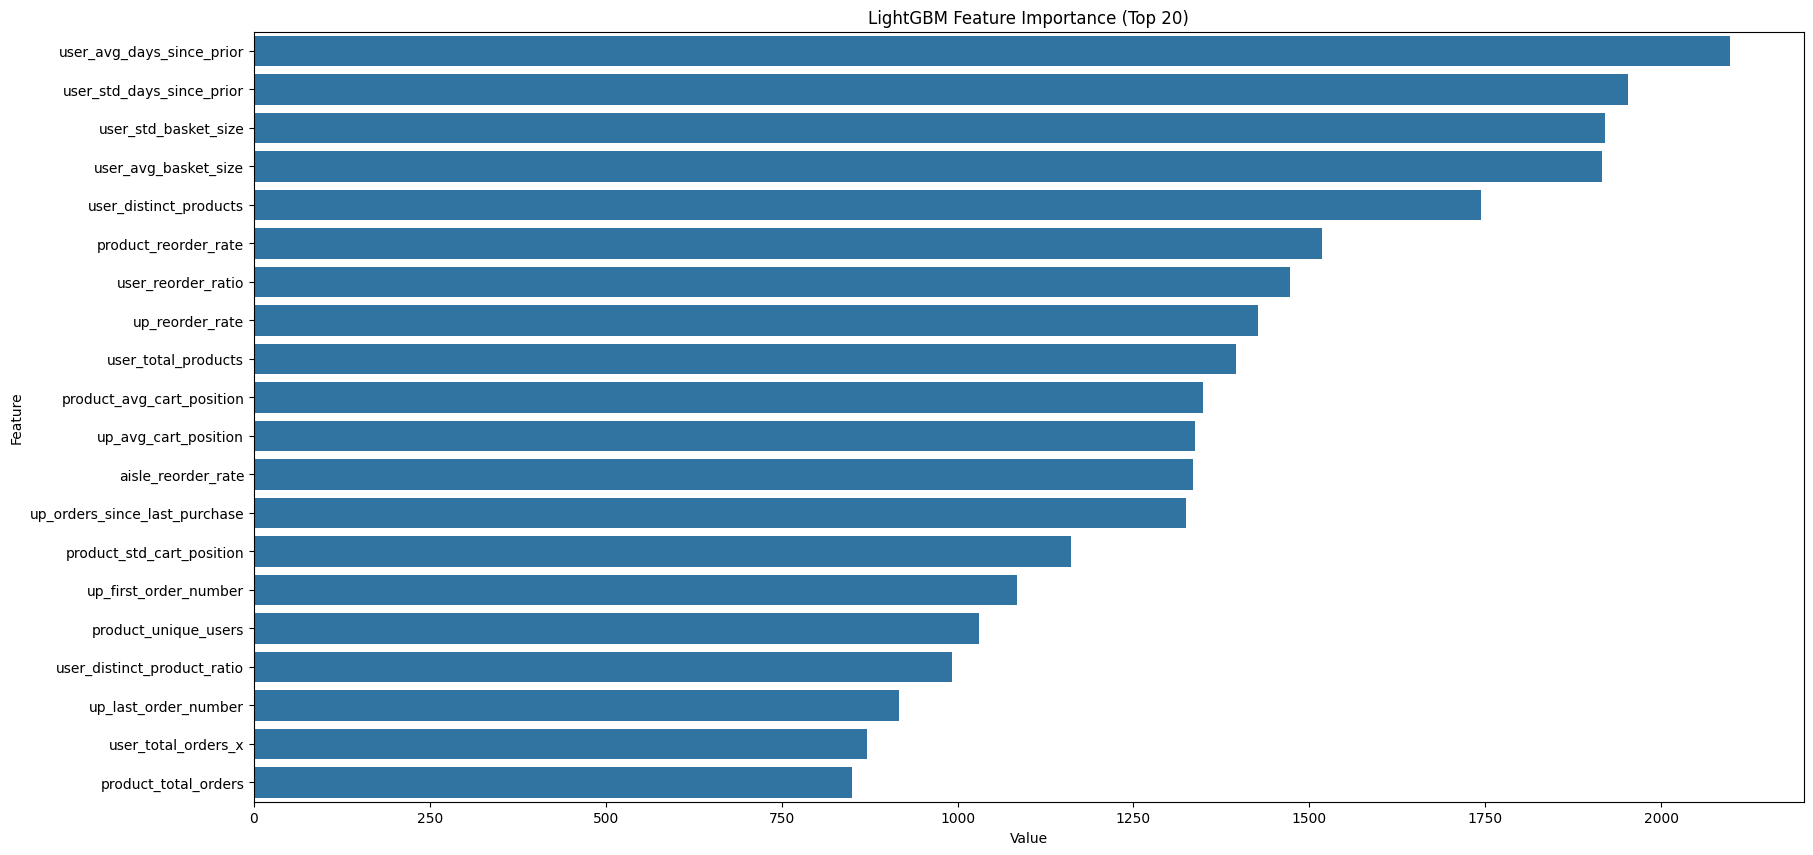

In [64]:

# Plot feature importance for LightGBM (often easier to read)
feature_imp = pd.DataFrame(sorted(zip(lgb_clf.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Feature Importance (Top 20)')
plt.show()


In [65]:
# --- Assemble the Test Data (CORRECTED) ---
print("Assembling the test dataset...")

# 1. Identify the test orders and their corresponding users
test_orders = orders[orders['eval_set'] == 'test']

# 2. Start with the User-Product features for the test users. This is our base.
# This DataFrame already contains all the 'up_' features.
test_data = up_features[up_features['user_id'].isin(test_orders['user_id'])]

# 3. Merge the other two feature sets (User and Product) onto this base.
print("Merging User and Product features onto test candidates...")
test_data = test_data.merge(user_features, on='user_id', how='left')
test_data = test_data.merge(product_features, on='product_id', how='left')

# 4. Add the order_id for submission purposes.
test_data = test_data.merge(test_orders[['user_id', 'order_id']], on='user_id', how='left')

# 5. Ensure the feature columns in 'test_data' are in the same order as in 'X_train'.
# This line should now work correctly because the column names were not altered.
X_test = test_data[X_train.columns]

print("Test dataset is ready.")
print("Shape of the test feature set:", X_test.shape)

Assembling the test dataset...
Merging User and Product features onto test candidates...
Test dataset is ready.
Shape of the test feature set: (4833292, 24)


In [66]:
# --- Make Predictions on the Test Set ---
print("\nMaking predictions with LightGBM model...")

# Use predict_proba to get the probability of the positive class (reordered=1)
test_predictions_proba = lgb_clf.predict_proba(X_test)[:, 1]

# Add the predictions back to our test_data DataFrame to keep everything organized
test_data['reorder_prediction'] = test_predictions_proba

print("Predictions are complete.")
print("Example predictions:")
print(test_data[['user_id', 'order_id', 'product_id', 'reorder_prediction']].head())


Making predictions with LightGBM model...
Predictions are complete.
Example predictions:
   user_id  order_id  product_id  reorder_prediction
0        3   2774568         248            0.022709
1        3   2774568        1005            0.055319
2        3   2774568        1819            0.122122
3        3   2774568        7503            0.028651
4        3   2774568        8021            0.043543


In [66]:
from sklearn.metrics import f1_score
import numpy as np

# --- Find the Optimal F1 Threshold ---
print("\nFinding the best F1 threshold on the validation set...")

# Predict probabilities on the validation set (X_val) that we created earlier
y_val_pred_proba = lgb_clf.predict_proba(X_val)[:, 1]

# Test a range of potential thresholds
thresholds = np.linspace(0, 0.5, 51)
f1_scores = [f1_score(y_val, y_val_pred_proba > t) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold:.4f}")
print(f"Best F1 Score on validation set: {np.max(f1_scores):.4f}")


# --- Generate the Final Submission File ---
print("\nGenerating submission file...")

# Apply the best threshold to our test predictions
test_data['reorder_prediction_binary'] = (test_data['reorder_prediction'] > best_threshold).astype(int)

# Filter for only the products predicted to be reordered
final_predictions = test_data[test_data['reorder_prediction_binary'] == 1]

# The submission format requires a space-separated list of product_ids for each order_id.
# We'll handle cases where an order has no reordered products predicted, submitting 'None'.
submission = final_predictions.groupby('order_id')['product_id'].apply(
    lambda x: ' '.join(map(str, x))
).reset_index()
submission.rename(columns={'product_id': 'products'}, inplace=True)

# Ensure all test orders are in the submission file
all_test_orders = test_orders[['order_id']]
submission = all_test_orders.merge(submission, on='order_id', how='left')

# Fill any orders with no predicted reorders with the string 'None'
submission['products'].fillna('None', inplace=True)

# Save the submission file
submission_filename = 'submission.csv'
submission.to_csv(submission_filename, index=False)

print(f"Submission file '{submission_filename}' created successfully.")
print("Submission head:")
print(submission.head())


Finding the best F1 threshold on the validation set...
Best threshold: 0.2200
Best F1 Score on validation set: 0.4429

Generating submission file...
Submission file 'submission.csv' created successfully.
Submission head:
   order_id                                           products
0   2774568          17668 18599 21903 23650 39190 43961 47766
1    329954                                               None
2   1528013                                        21903 38293
3   1376945  8309 13176 14947 24799 27959 28465 33572 34658...
4   1356845           7076 10863 11520 13176 14992 22959 28134


C:\Users\abhir\AppData\Local\Temp\ipykernel_14024\4186688377.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  submission['products'].fillna('None', inplace=True)


In [67]:
from sklearn.metrics import f1_score
import numpy as np

# --- XGBoost: Find Optimal Threshold and Create Submission ---

print("--- Running Prediction Pipeline for XGBoost ---")

# --- Step 1: Find the Optimal F1 Threshold (using XGBoost) ---
print("\nFinding the best F1 threshold for XGBoost on the validation set...")

# Predict probabilities on the validation set (X_val) using the trained XGBoost model
y_val_pred_proba_xgb = xgb_clf.predict_proba(X_val)[:, 1]

# Test a range of potential thresholds (can use the same range as before)
thresholds = np.linspace(0, 0.5, 51)
f1_scores_xgb = [f1_score(y_val, y_val_pred_proba_xgb > t) for t in thresholds]

best_threshold_xgb = thresholds[np.argmax(f1_scores_xgb)]
print(f"Best threshold for XGBoost: {best_threshold_xgb:.4f}")
print(f"Best F1 Score on validation set for XGBoost: {np.max(f1_scores_xgb):.4f}")


# --- Step 2: Make Predictions on the Test Set ---
print("\nMaking predictions on the test set with XGBoost model...")

# Use the trained xgb_clf model to predict probabilities on the test set (X_test)
test_predictions_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Add these new predictions to our main test_data DataFrame
test_data['reorder_prediction_xgb'] = test_predictions_proba_xgb


# --- Step 3: Generate the Final Submission File for XGBoost ---
print("\nGenerating XGBoost submission file...")

# Apply the XGBoost-specific best threshold to the XGBoost predictions
test_data['reorder_prediction_binary_xgb'] = (test_data['reorder_prediction_xgb'] > best_threshold_xgb).astype(int)

# Filter for only the products predicted to be reordered by XGBoost
final_predictions_xgb = test_data[test_data['reorder_prediction_binary_xgb'] == 1]

# Group the predictions by order_id
submission_xgb = final_predictions_xgb.groupby('order_id')['product_id'].apply(
    lambda x: ' '.join(map(str, x))
).reset_index()
submission_xgb.rename(columns={'product_id': 'products'}, inplace=True)

# Ensure all test orders are in the submission file
all_test_orders = test_orders[['order_id']]
submission_xgb = all_test_orders.merge(submission_xgb, on='order_id', how='left')

# Fill any orders with no predicted reorders with the string 'None'
# Using the safer, modern pandas syntax to avoid the warning
submission_xgb['products'] = submission_xgb['products'].fillna('None')

# Save the submission file with a new name
submission_filename_xgb = 'submission_xgb.csv'
submission_xgb.to_csv(submission_filename_xgb, index=False)

print(f"Submission file '{submission_filename_xgb}' created successfully.")
print("XGBoost Submission head:")
print(submission_xgb.head())

--- Running Prediction Pipeline for XGBoost ---

Finding the best F1 threshold for XGBoost on the validation set...
Best threshold for XGBoost: 0.2200
Best F1 Score on validation set for XGBoost: 0.4444

Making predictions on the test set with XGBoost model...

Generating XGBoost submission file...
Submission file 'submission_xgb.csv' created successfully.
XGBoost Submission head:
   order_id                                  products
0   2774568       17668 18599 21903 39190 43961 47766
1    329954                                      None
2   1528013                               21903 38293
3   1376945        8309 13176 14947 27959 33572 44632
4   1356845  7076 10863 11520 13176 14992 21616 28134


In [68]:
# --- Create an Ensemble Prediction ---
print("--- Creating an Ensemble of LightGBM and XGBoost ---")

# 1. Create the blended probability prediction
# We already have the predictions stored in our test_data DataFrame
# Let's give equal weight to both models
test_data['ensemble_prediction'] = 0.5 * test_data['reorder_prediction'] + 0.5 * test_data['reorder_prediction_xgb']

# 2. Find the optimal F1 threshold for the ENSEMBLE predictions
print("\nFinding the best F1 threshold for the ENSEMBLE on the validation set...")

# First, create the blended probabilities for the validation set
y_val_pred_proba_lgb = lgb_clf.predict_proba(X_val)[:, 1]
y_val_pred_proba_xgb = xgb_clf.predict_proba(X_val)[:, 1]
y_val_pred_proba_ensemble = 0.5 * y_val_pred_proba_lgb + 0.5 * y_val_pred_proba_xgb

# Now find the best threshold for these new blended probabilities
thresholds = np.linspace(0, 0.5, 51)
f1_scores_ensemble = [f1_score(y_val, y_val_pred_proba_ensemble > t) for t in thresholds]
best_threshold_ensemble = thresholds[np.argmax(f1_scores_ensemble)]

print(f"Best threshold for Ensemble: {best_threshold_ensemble:.4f}")
print(f"Best F1 Score on validation set for Ensemble: {np.max(f1_scores_ensemble):.4f}")


# 3. Generate the final submission file for the Ensemble
print("\nGenerating Ensemble submission file...")

# Apply the new ensemble-specific threshold
test_data['reorder_prediction_binary_ensemble'] = (test_data['ensemble_prediction'] > best_threshold_ensemble).astype(int)

# Filter and group to create the submission file
final_predictions_ensemble = test_data[test_data['reorder_prediction_binary_ensemble'] == 1]
submission_ensemble = final_predictions_ensemble.groupby('order_id')['product_id'].apply(
    lambda x: ' '.join(map(str, x))
).reset_index()
submission_ensemble.rename(columns={'product_id': 'products'}, inplace=True)

# Merge to ensure all test orders are included
all_test_orders = test_orders[['order_id']]
submission_ensemble = all_test_orders.merge(submission_ensemble, on='order_id', how='left')
submission_ensemble['products'] = submission_ensemble['products'].fillna('None')

# Save the final submission file
submission_filename_ensemble = 'submission_ensemble.csv'
submission_ensemble.to_csv(submission_filename_ensemble, index=False)

print(f"Submission file '{submission_filename_ensemble}' created successfully.")
print("Ensemble Submission head:")
print(submission_ensemble.head())

--- Creating an Ensemble of LightGBM and XGBoost ---

Finding the best F1 threshold for the ENSEMBLE on the validation set...
Best threshold for Ensemble: 0.2200
Best F1 Score on validation set for Ensemble: 0.4440

Generating Ensemble submission file...
Submission file 'submission_ensemble.csv' created successfully.
Ensemble Submission head:
   order_id                                           products
0   2774568                17668 18599 21903 39190 43961 47766
1    329954                                               None
2   1528013                                        21903 38293
3   1376945  8309 13176 14947 24799 27959 28465 33572 34658...
4   1356845     7076 10863 11520 13176 14992 21616 22959 28134


In [71]:
import optuna
from sklearn.metrics import f1_score
import xgboost as xgb

# --- Hyperparameter Tuning with Optuna ---

def objective(trial):
    """
    Define the objective function for Optuna to optimize.
    A 'trial' is a single run with a specific set of hyperparameters.
    """
    # 1. Suggest a set of hyperparameters for this trial
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000, # High n_estimators, will use early stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'early_stopping_rounds':50,
        'gamma': trial.suggest_float('gamma', 0, 0.5)
    }

    # 2. Train the XGBoost model with the suggested params
    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False) # Keep the output clean during tuning

    # 3. Evaluate the model and find the best F1 score
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # We need to find the best threshold for *this specific trial*
    thresholds = np.linspace(0, 0.5, 26) # Check a smaller range of thresholds to speed up tuning
    f1_scores = [f1_score(y_val, y_pred_proba > t) for t in thresholds]
    
    best_f1 = np.max(f1_scores)
    
    # 4. Return the score to be maximized
    return best_f1

# --- Run the study ---
# We want to MAXIMIZE the F1 score, so we set direction='maximize'
study = optuna.create_study(direction='maximize')

# Start the optimization. n_trials=50 is a good starting point.
# For a serious attempt, you might run 100-200 trials.
print("Starting hyperparameter tuning for XGBoost...")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# --- Print the results ---
print("\nTuning complete.")
print(f"Best trial F1 score: {study.best_value:.4f}")
print("Best parameters found:")
print(study.best_params)

[I 2025-06-18 22:24:06,311] A new study created in memory with name: no-name-10e5736f-c1bb-4fee-937f-876583212b96


Starting hyperparameter tuning for XGBoost...


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:24:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.44461:   2%|▏         | 1/50 [06:45<5:31:33, 405.98s/it]

[I 2025-06-18 22:30:52,291] Trial 0 finished with value: 0.4446103528624073 and parameters: {'learning_rate': 0.12580278832913414, 'max_depth': 7, 'subsample': 0.5624595696041073, 'colsample_bytree': 0.7767236009421671, 'min_child_weight': 7, 'gamma': 0.12315297805977238}. Best is trial 0 with value: 0.4446103528624073.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:30:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.44461:   4%|▍         | 2/50 [11:11<4:18:54, 323.63s/it]

[I 2025-06-18 22:35:18,276] Trial 1 finished with value: 0.4414462831905497 and parameters: {'learning_rate': 0.21283131215372775, 'max_depth': 4, 'subsample': 0.544704395629168, 'colsample_bytree': 0.837259182096337, 'min_child_weight': 7, 'gamma': 0.2203646649043421}. Best is trial 0 with value: 0.4446103528624073.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:35:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 2. Best value: 0.444995:   6%|▌         | 3/50 [17:48<4:39:41, 357.06s/it]

[I 2025-06-18 22:41:55,121] Trial 2 finished with value: 0.4449953764229457 and parameters: {'learning_rate': 0.18754329275092274, 'max_depth': 6, 'subsample': 0.7992929056881228, 'colsample_bytree': 0.7752135779154636, 'min_child_weight': 9, 'gamma': 0.10300202278829623}. Best is trial 2 with value: 0.4449953764229457.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:41:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 2. Best value: 0.444995:   8%|▊         | 4/50 [22:12<4:05:31, 320.25s/it]

[I 2025-06-18 22:46:18,925] Trial 3 finished with value: 0.44442559103237456 and parameters: {'learning_rate': 0.20417770657927486, 'max_depth': 8, 'subsample': 0.7148285776963952, 'colsample_bytree': 0.5119953686623246, 'min_child_weight': 6, 'gamma': 0.3116447053620986}. Best is trial 2 with value: 0.4449953764229457.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:46:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 2. Best value: 0.444995:  10%|█         | 5/50 [24:59<3:18:45, 265.01s/it]

[I 2025-06-18 22:49:06,006] Trial 4 finished with value: 0.44420137086436495 and parameters: {'learning_rate': 0.26606084791897183, 'max_depth': 9, 'subsample': 0.8330799066551616, 'colsample_bytree': 0.5478340590798899, 'min_child_weight': 9, 'gamma': 0.4247061931729047}. Best is trial 2 with value: 0.4449953764229457.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:49:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 2. Best value: 0.444995:  12%|█▏        | 6/50 [26:03<2:24:11, 196.62s/it]

[I 2025-06-18 22:50:09,866] Trial 5 finished with value: 0.438940226927126 and parameters: {'learning_rate': 0.28655761236480115, 'max_depth': 9, 'subsample': 0.518057546866693, 'colsample_bytree': 0.9041637972570218, 'min_child_weight': 10, 'gamma': 0.20443793303147018}. Best is trial 2 with value: 0.4449953764229457.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:50:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 6. Best value: 0.445195:  14%|█▍        | 7/50 [33:02<3:13:03, 269.39s/it]

[I 2025-06-18 22:57:09,071] Trial 6 finished with value: 0.4451946799235749 and parameters: {'learning_rate': 0.19070674089509412, 'max_depth': 8, 'subsample': 0.734345208406857, 'colsample_bytree': 0.8740420151571189, 'min_child_weight': 6, 'gamma': 0.05508576930741832}. Best is trial 6 with value: 0.4451946799235749.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:57:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 6. Best value: 0.445195:  16%|█▌        | 8/50 [38:30<3:21:35, 287.98s/it]

[I 2025-06-18 23:02:36,864] Trial 7 finished with value: 0.43908034886276526 and parameters: {'learning_rate': 0.017168075433336302, 'max_depth': 5, 'subsample': 0.5827307259811962, 'colsample_bytree': 0.8053196132809739, 'min_child_weight': 7, 'gamma': 0.1708854898874777}. Best is trial 6 with value: 0.4451946799235749.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:02:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 6. Best value: 0.445195:  18%|█▊        | 9/50 [42:40<3:08:37, 276.03s/it]

[I 2025-06-18 23:06:46,628] Trial 8 finished with value: 0.4400110167202796 and parameters: {'learning_rate': 0.07955373855615043, 'max_depth': 4, 'subsample': 0.7141054137560499, 'colsample_bytree': 0.573313586940617, 'min_child_weight': 9, 'gamma': 0.4357953093908653}. Best is trial 6 with value: 0.4451946799235749.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 6. Best value: 0.445195:  20%|██        | 10/50 [46:21<2:52:39, 258.98s/it]

[I 2025-06-18 23:10:27,424] Trial 9 finished with value: 0.4429407023787674 and parameters: {'learning_rate': 0.24077355828589841, 'max_depth': 6, 'subsample': 0.6434338494504034, 'colsample_bytree': 0.5263602782244976, 'min_child_weight': 1, 'gamma': 0.15173932861184852}. Best is trial 6 with value: 0.4451946799235749.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:10:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 10. Best value: 0.447403:  22%|██▏       | 11/50 [51:26<2:57:37, 273.27s/it]

[I 2025-06-18 23:15:33,114] Trial 10 finished with value: 0.44740334189685554 and parameters: {'learning_rate': 0.14901897357882016, 'max_depth': 7, 'subsample': 0.8918828059391453, 'colsample_bytree': 0.9886129252336541, 'min_child_weight': 3, 'gamma': 0.005914909865627094}. Best is trial 10 with value: 0.44740334189685554.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 10. Best value: 0.447403:  24%|██▍       | 12/50 [56:19<2:56:51, 279.25s/it]

[I 2025-06-18 23:20:26,004] Trial 11 finished with value: 0.44679148578704897 and parameters: {'learning_rate': 0.13798366213220148, 'max_depth': 7, 'subsample': 0.9928234799312988, 'colsample_bytree': 0.997363920393525, 'min_child_weight': 3, 'gamma': 0.007030273325115383}. Best is trial 10 with value: 0.44740334189685554.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 10. Best value: 0.447403:  26%|██▌       | 13/50 [1:00:59<2:52:15, 279.33s/it]

[I 2025-06-18 23:25:05,549] Trial 12 finished with value: 0.4470494460238595 and parameters: {'learning_rate': 0.1258607397670042, 'max_depth': 7, 'subsample': 0.9765950885374324, 'colsample_bytree': 0.9868967990304551, 'min_child_weight': 2, 'gamma': 0.00794523611337015}. Best is trial 10 with value: 0.44740334189685554.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:25:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 10. Best value: 0.447403:  28%|██▊       | 14/50 [1:06:24<2:55:54, 293.17s/it]

[I 2025-06-18 23:30:30,694] Trial 13 finished with value: 0.44558032303322176 and parameters: {'learning_rate': 0.08002161814087153, 'max_depth': 7, 'subsample': 0.9804287565460751, 'colsample_bytree': 0.9901154111344764, 'min_child_weight': 3, 'gamma': 0.008923508274250033}. Best is trial 10 with value: 0.44740334189685554.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:30:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 10. Best value: 0.447403:  30%|███       | 15/50 [1:10:01<2:37:40, 270.29s/it]

[I 2025-06-18 23:34:07,970] Trial 14 finished with value: 0.439288650379856 and parameters: {'learning_rate': 0.10112437424646228, 'max_depth': 3, 'subsample': 0.8877067847607142, 'colsample_bytree': 0.6446212180967297, 'min_child_weight': 3, 'gamma': 0.34277226990050247}. Best is trial 10 with value: 0.44740334189685554.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:34:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 10. Best value: 0.447403:  32%|███▏      | 16/50 [1:15:28<2:42:53, 287.46s/it]

[I 2025-06-18 23:39:35,283] Trial 15 finished with value: 0.4421879332039498 and parameters: {'learning_rate': 0.041959565590623776, 'max_depth': 6, 'subsample': 0.9088534561673287, 'colsample_bytree': 0.9277799337395639, 'min_child_weight': 1, 'gamma': 0.07215109250611204}. Best is trial 10 with value: 0.44740334189685554.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:39:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 16. Best value: 0.448225:  34%|███▍      | 17/50 [1:25:49<3:33:15, 387.74s/it]

[I 2025-06-18 23:49:56,209] Trial 16 finished with value: 0.4482248717070594 and parameters: {'learning_rate': 0.16240850670424822, 'max_depth': 8, 'subsample': 0.9269522827936151, 'colsample_bytree': 0.6565073090767827, 'min_child_weight': 4, 'gamma': 0.3025492957411847}. Best is trial 16 with value: 0.4482248717070594.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:50:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  36%|███▌      | 18/50 [1:33:12<3:35:30, 404.08s/it]

[I 2025-06-18 23:57:18,356] Trial 17 finished with value: 0.4486674489879712 and parameters: {'learning_rate': 0.1679565174411024, 'max_depth': 8, 'subsample': 0.902561365241769, 'colsample_bytree': 0.6867835810382348, 'min_child_weight': 4, 'gamma': 0.2774349246149336}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [23:57:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  38%|███▊      | 19/50 [1:39:42<3:26:36, 399.89s/it]

[I 2025-06-19 00:03:48,501] Trial 18 finished with value: 0.4474766394812665 and parameters: {'learning_rate': 0.17116274282038066, 'max_depth': 8, 'subsample': 0.8164985231132093, 'colsample_bytree': 0.7082285622310209, 'min_child_weight': 5, 'gamma': 0.3266530793409319}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:03:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  40%|████      | 20/50 [1:43:03<2:50:06, 340.20s/it]

[I 2025-06-19 00:07:09,581] Trial 19 finished with value: 0.44617914644173895 and parameters: {'learning_rate': 0.23592808581482966, 'max_depth': 9, 'subsample': 0.9263195492968642, 'colsample_bytree': 0.6481520225044018, 'min_child_weight': 5, 'gamma': 0.4987744165753944}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:07:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  42%|████▏     | 21/50 [1:49:56<2:55:04, 362.23s/it]

[I 2025-06-19 00:14:03,177] Trial 20 finished with value: 0.44780087126779544 and parameters: {'learning_rate': 0.16559934594956055, 'max_depth': 8, 'subsample': 0.8526158100939742, 'colsample_bytree': 0.716432617064646, 'min_child_weight': 4, 'gamma': 0.27523359293890864}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:14:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  44%|████▍     | 22/50 [1:57:14<2:59:39, 384.99s/it]

[I 2025-06-19 00:21:21,226] Trial 21 finished with value: 0.4478979823602458 and parameters: {'learning_rate': 0.16245861811622345, 'max_depth': 8, 'subsample': 0.8576283231243884, 'colsample_bytree': 0.7041998867633258, 'min_child_weight': 4, 'gamma': 0.27563564181444283}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:21:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  46%|████▌     | 23/50 [2:06:12<3:13:52, 430.83s/it]

[I 2025-06-19 00:30:18,993] Trial 22 finished with value: 0.4472579002103886 and parameters: {'learning_rate': 0.1080960514244972, 'max_depth': 8, 'subsample': 0.7787502640925242, 'colsample_bytree': 0.6474282025386171, 'min_child_weight': 4, 'gamma': 0.2671667367840878}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:30:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  48%|████▊     | 24/50 [2:14:50<3:17:58, 456.85s/it]

[I 2025-06-19 00:38:56,546] Trial 23 finished with value: 0.4485239842600804 and parameters: {'learning_rate': 0.16386302288548302, 'max_depth': 9, 'subsample': 0.9464758896558133, 'colsample_bytree': 0.5943115049522005, 'min_child_weight': 4, 'gamma': 0.3824539988162086}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:39:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  50%|█████     | 25/50 [2:21:01<2:59:38, 431.13s/it]

[I 2025-06-19 00:45:07,673] Trial 24 finished with value: 0.4469388620368015 and parameters: {'learning_rate': 0.221073106943959, 'max_depth': 9, 'subsample': 0.9433640595377895, 'colsample_bytree': 0.5945603070177917, 'min_child_weight': 5, 'gamma': 0.3960579091017219}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:45:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 17. Best value: 0.448667:  52%|█████▏    | 26/50 [2:27:46<2:49:21, 423.38s/it]

[I 2025-06-19 00:51:52,952] Trial 25 finished with value: 0.44850438356600836 and parameters: {'learning_rate': 0.17886252292194565, 'max_depth': 9, 'subsample': 0.9469758108588843, 'colsample_bytree': 0.6068505350940014, 'min_child_weight': 2, 'gamma': 0.3786956648799554}. Best is trial 17 with value: 0.4486674489879712.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:51:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  54%|█████▍    | 27/50 [2:35:31<2:47:04, 435.86s/it]

[I 2025-06-19 00:59:37,942] Trial 26 finished with value: 0.44873207501081935 and parameters: {'learning_rate': 0.1882429387491997, 'max_depth': 9, 'subsample': 0.9525393735184826, 'colsample_bytree': 0.6030490048831125, 'min_child_weight': 2, 'gamma': 0.3772433852924712}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:59:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  56%|█████▌    | 28/50 [2:39:11<2:16:01, 370.96s/it]

[I 2025-06-19 01:03:17,490] Trial 27 finished with value: 0.44516826655500136 and parameters: {'learning_rate': 0.2505367141078649, 'max_depth': 9, 'subsample': 0.8663051029461731, 'colsample_bytree': 0.607831796851698, 'min_child_weight': 2, 'gamma': 0.3650183935078106}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:03:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  58%|█████▊    | 29/50 [2:44:41<2:05:35, 358.84s/it]

[I 2025-06-19 01:08:48,039] Trial 28 finished with value: 0.44672287826013085 and parameters: {'learning_rate': 0.19867382655950205, 'max_depth': 9, 'subsample': 0.9563434555340938, 'colsample_bytree': 0.6834802804689404, 'min_child_weight': 2, 'gamma': 0.46427336876928904}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:08:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  60%|██████    | 30/50 [2:53:30<2:16:39, 409.95s/it]

[I 2025-06-19 01:17:37,250] Trial 29 finished with value: 0.44793447217827986 and parameters: {'learning_rate': 0.13224226038842746, 'max_depth': 9, 'subsample': 0.7692025068575065, 'colsample_bytree': 0.753222641809145, 'min_child_weight': 1, 'gamma': 0.4064592303124276}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:17:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  62%|██████▏   | 31/50 [3:01:00<2:13:33, 421.75s/it]

[I 2025-06-19 01:25:06,526] Trial 30 finished with value: 0.44178975614825633 and parameters: {'learning_rate': 0.10141043553287875, 'max_depth': 5, 'subsample': 0.9975066892741238, 'colsample_bytree': 0.5755517032294799, 'min_child_weight': 6, 'gamma': 0.3565160348047928}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:25:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  64%|██████▍   | 32/50 [3:07:57<2:06:08, 420.49s/it]

[I 2025-06-19 01:32:04,066] Trial 31 finished with value: 0.44786381877846165 and parameters: {'learning_rate': 0.1817987018963626, 'max_depth': 9, 'subsample': 0.9547958528668692, 'colsample_bytree': 0.6203338002566967, 'min_child_weight': 2, 'gamma': 0.39190800781923774}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:32:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  66%|██████▌   | 33/50 [3:13:14<1:50:20, 389.45s/it]

[I 2025-06-19 01:37:21,109] Trial 32 finished with value: 0.4460998659055615 and parameters: {'learning_rate': 0.21491212370022714, 'max_depth': 9, 'subsample': 0.8978290601798106, 'colsample_bytree': 0.5554181569136579, 'min_child_weight': 3, 'gamma': 0.23375575252337824}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:37:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  68%|██████▊   | 34/50 [3:22:03<1:55:00, 431.25s/it]

[I 2025-06-19 01:46:09,889] Trial 33 finished with value: 0.4483678185343568 and parameters: {'learning_rate': 0.14566157786302403, 'max_depth': 8, 'subsample': 0.9550290489328506, 'colsample_bytree': 0.6171491653698745, 'min_child_weight': 2, 'gamma': 0.36657164851197066}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  70%|███████   | 35/50 [3:29:03<1:46:59, 427.95s/it]

[I 2025-06-19 01:53:10,130] Trial 34 finished with value: 0.447402288968319 and parameters: {'learning_rate': 0.18007247311795693, 'max_depth': 9, 'subsample': 0.9258979723545709, 'colsample_bytree': 0.6775023478269687, 'min_child_weight': 4, 'gamma': 0.4591777404419045}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:53:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  72%|███████▏  | 36/50 [3:35:07<1:35:20, 408.59s/it]

[I 2025-06-19 01:59:13,541] Trial 35 finished with value: 0.4450928635033711 and parameters: {'learning_rate': 0.22128943167248272, 'max_depth': 8, 'subsample': 0.8836621084967574, 'colsample_bytree': 0.5108930562159777, 'min_child_weight': 1, 'gamma': 0.3131590971153374}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [01:59:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  74%|███████▍  | 37/50 [3:43:02<1:32:50, 428.50s/it]

[I 2025-06-19 02:07:08,486] Trial 36 finished with value: 0.4463250723829256 and parameters: {'learning_rate': 0.2028616303180359, 'max_depth': 7, 'subsample': 0.8306061140758407, 'colsample_bytree': 0.7482219556408889, 'min_child_weight': 5, 'gamma': 0.2006249981860075}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 26. Best value: 0.448732:  76%|███████▌  | 38/50 [3:50:08<1:25:34, 427.91s/it]

[I 2025-06-19 02:14:15,034] Trial 37 finished with value: 0.44766614537103566 and parameters: {'learning_rate': 0.1856884654016532, 'max_depth': 9, 'subsample': 0.9581483577468191, 'colsample_bytree': 0.5386395840552151, 'min_child_weight': 7, 'gamma': 0.42902682062607816}. Best is trial 26 with value: 0.44873207501081935.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:14:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 38. Best value: 0.449124:  78%|███████▊  | 39/50 [3:58:53<1:23:46, 456.92s/it]

[I 2025-06-19 02:22:59,654] Trial 38 finished with value: 0.4491239999575015 and parameters: {'learning_rate': 0.11569470683239357, 'max_depth': 9, 'subsample': 0.9161478771644366, 'colsample_bytree': 0.5788715071187444, 'min_child_weight': 3, 'gamma': 0.37979243312321914}. Best is trial 38 with value: 0.4491239999575015.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:23:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 38. Best value: 0.449124:  80%|████████  | 40/50 [4:07:58<1:20:33, 483.38s/it]

[I 2025-06-19 02:32:04,773] Trial 39 finished with value: 0.4478701652978259 and parameters: {'learning_rate': 0.11982710226934488, 'max_depth': 8, 'subsample': 0.9161436271115126, 'colsample_bytree': 0.5681197671838552, 'min_child_weight': 3, 'gamma': 0.33769527056044935}. Best is trial 38 with value: 0.4491239999575015.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:32:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 38. Best value: 0.449124:  82%|████████▏ | 41/50 [4:18:12<1:18:22, 522.49s/it]

[I 2025-06-19 02:42:18,526] Trial 40 finished with value: 0.44654628223775705 and parameters: {'learning_rate': 0.0698920351393028, 'max_depth': 9, 'subsample': 0.634372929767149, 'colsample_bytree': 0.590907686502372, 'min_child_weight': 7, 'gamma': 0.29576033170829025}. Best is trial 38 with value: 0.4491239999575015.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:42:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 41. Best value: 0.449497:  84%|████████▍ | 42/50 [4:27:40<1:11:29, 536.19s/it]

[I 2025-06-19 02:51:46,661] Trial 41 finished with value: 0.4494970395365124 and parameters: {'learning_rate': 0.14851305449554678, 'max_depth': 9, 'subsample': 0.9309273399644609, 'colsample_bytree': 0.5001049153727103, 'min_child_weight': 2, 'gamma': 0.37041954148072287}. Best is trial 41 with value: 0.4494970395365124.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:51:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 41. Best value: 0.449497:  86%|████████▌ | 43/50 [4:35:00<59:11, 507.34s/it]  

[I 2025-06-19 02:59:06,688] Trial 42 finished with value: 0.4487828430748334 and parameters: {'learning_rate': 0.15272243598944063, 'max_depth': 9, 'subsample': 0.9720663686857024, 'colsample_bytree': 0.5018518995924887, 'min_child_weight': 4, 'gamma': 0.41565851980780455}. Best is trial 41 with value: 0.4494970395365124.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:59:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 41. Best value: 0.449497:  88%|████████▊ | 44/50 [4:43:22<50:33, 505.66s/it]

[I 2025-06-19 03:07:28,441] Trial 43 finished with value: 0.44779717262892416 and parameters: {'learning_rate': 0.14821404583434772, 'max_depth': 8, 'subsample': 0.9761159685426631, 'colsample_bytree': 0.5038718325127148, 'min_child_weight': 3, 'gamma': 0.45554753732239633}. Best is trial 41 with value: 0.4494970395365124.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:07:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 41. Best value: 0.449497:  90%|█████████ | 45/50 [4:52:59<43:56, 527.30s/it]

[I 2025-06-19 03:17:06,218] Trial 44 finished with value: 0.44947756492893765 and parameters: {'learning_rate': 0.11267338677403678, 'max_depth': 9, 'subsample': 0.8546841165665947, 'colsample_bytree': 0.5343650755086629, 'min_child_weight': 2, 'gamma': 0.4074276582582925}. Best is trial 41 with value: 0.4494970395365124.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 45. Best value: 0.449681:  92%|█████████▏| 46/50 [5:02:34<36:05, 541.46s/it]

[I 2025-06-19 03:26:40,725] Trial 45 finished with value: 0.44968115633967476 and parameters: {'learning_rate': 0.1141648221029631, 'max_depth': 9, 'subsample': 0.8604942318943458, 'colsample_bytree': 0.528809325492026, 'min_child_weight': 1, 'gamma': 0.41663601859599436}. Best is trial 45 with value: 0.44968115633967476.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:26:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 45. Best value: 0.449681:  94%|█████████▍| 47/50 [5:09:31<25:12, 504.12s/it]

[I 2025-06-19 03:33:37,716] Trial 46 finished with value: 0.44199210871487454 and parameters: {'learning_rate': 0.11608554528525518, 'max_depth': 5, 'subsample': 0.8060462826617186, 'colsample_bytree': 0.5350070943551128, 'min_child_weight': 1, 'gamma': 0.4881511806527416}. Best is trial 45 with value: 0.44968115633967476.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:33:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 45. Best value: 0.449681:  96%|█████████▌| 48/50 [5:16:04<15:41, 470.72s/it]

[I 2025-06-19 03:40:10,497] Trial 47 finished with value: 0.43957185741791566 and parameters: {'learning_rate': 0.09069659087031776, 'max_depth': 3, 'subsample': 0.8429989692331331, 'colsample_bytree': 0.519375955315789, 'min_child_weight': 1, 'gamma': 0.43306925014913966}. Best is trial 45 with value: 0.44968115633967476.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:40:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 45. Best value: 0.449681:  98%|█████████▊| 49/50 [5:25:59<08:28, 508.06s/it]

[I 2025-06-19 03:50:05,682] Trial 48 finished with value: 0.4480967108309956 and parameters: {'learning_rate': 0.06489814565824638, 'max_depth': 9, 'subsample': 0.875508265359589, 'colsample_bytree': 0.5003474697660149, 'min_child_weight': 2, 'gamma': 0.4086309975587149}. Best is trial 45 with value: 0.44968115633967476.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [03:50:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 45. Best value: 0.449681: 100%|██████████| 50/50 [5:34:01<00:00, 400.84s/it]

[I 2025-06-19 03:58:08,114] Trial 49 finished with value: 0.4455192170222717 and parameters: {'learning_rate': 0.13704130882962504, 'max_depth': 7, 'subsample': 0.709933737863388, 'colsample_bytree': 0.5468805202001132, 'min_child_weight': 8, 'gamma': 0.4159234769726423}. Best is trial 45 with value: 0.44968115633967476.

Tuning complete.
Best trial F1 score: 0.4497
Best parameters found:
{'learning_rate': 0.1141648221029631, 'max_depth': 9, 'subsample': 0.8604942318943458, 'colsample_bytree': 0.528809325492026, 'min_child_weight': 1, 'gamma': 0.41663601859599436}


In [ ]:
print("\nRe-training XGBoost with the best found parameters...")

# 1. Retrieve and update best parameters
best_params = study.best_params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
})
# High upper bound, early stopping will cut it down
best_params['n_estimators'] = 2000

# 2. Initialize model with constructor-based early stopping
final_xgb_tuned = xgb.XGBClassifier(
    **best_params,
    random_state=42,
    early_stopping_rounds=100  # ✔️ Must go here, not in fit()
)

# (Optional) Alternatively, with callback interface in constructor:
# early_stop = EarlyStopping(rounds=100, save_best=True, metric_name='logloss')
# final_xgb_tuned = xgb.XGBClassifier(
#     **best_params,
#     random_state=42,
#     callbacks=[early_stop]
# )

# 3. Train model with validation monitor
final_xgb_tuned.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"📈 Early stopping triggered at iteration: {final_xgb_tuned.best_iteration}")

# 4. Determine optimal F1 threshold
print("\nFinding the best F1 threshold for the tuned model...")
y_val_proba = final_xgb_tuned.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0, 0.5, 51)
f1_scores = [f1_score(y_val, y_val_proba > t) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 Score on validation: {best_f1:.4f} at threshold {best_threshold:.4f}")

# 5. Generate the final submission
print("\nGenerating final submission file with the tuned model...")
test_proba = final_xgb_tuned.predict_proba(X_test)[:, 1]
test_data['reorder_prediction_binary_tuned'] = (test_proba > best_threshold).astype(int)

preds = test_data[test_data['reorder_prediction_binary_tuned'] == 1]
submission = (
    preds
    .groupby('order_id')['product_id']
    .apply(lambda x: ' '.join(map(str, x)))
    .reset_index()
    .rename(columns={'product_id': 'products'})
)

submission = test_orders[['order_id']].merge(submission, on='order_id', how='left')
submission['products'] = submission['products'].fillna('None')

submission_filename = 'submission_xgb_tuned.csv'
submission.to_csv(submission_filename, index=False)

print(f"\n✔ Submission file '{submission_filename}' created successfully.")



Re-training XGBoost with the best found parameters...


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [00:51:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


The top competitors realized that using a single, global F1 threshold (like the 0.22 we found) is a major weakness. A user who typically buys 20 items should have more predicted reorders than a user who buys 3. The best way to proceed is with Dynamic Thresholding, also called a "Top-N" strategy.


Instead of asking "Which products have a probability > 0.22?", we will ask a smarter question for each user:
"Based on this user's history, they typically reorder N items. What are the N products with the highest probability from my model?"
This personalizes the size of the predicted shopping basket for every single user.


The Plan
Estimate N: For each user, we will estimate their expected number of reorders (N) based on their prior order history. A simple and effective way is to calculate the average number of items they reordered in their past baskets.
Generate Submission: For each order_id in the test set, we will take the N products with the highest predicted probabilities from your already-trained tuned XGBoost model and submit those.


In [68]:
# --- Step 4: Re-train the FINAL Tuned XGBoost Model ---
print("\n Re-training the one final, tuned XGBoost model... ---")

# These are the best parameters you found from your Optuna run
best_params = {
    'learning_rate': 0.1141648221029631,
    'max_depth': 9,
    'subsample': 0.8604942318943458,
    'colsample_bytree': 0.528809325492026,
    'min_child_weight': 1,
    'gamma': 0.41663601859599436,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'n_estimators': 2000,
    'early_stopping_rounds': 100
}

# Initialize and train the model using the syntax that works for your environment
final_xgb_tuned = xgb.XGBClassifier(**best_params, random_state=42)
final_xgb_tuned.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False)



--- Step 4: Re-training the one final, tuned XGBoost model... ---


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.528809325492026, device=None,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.41663601859599436, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1141648221029631,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, ...)

In [69]:
# --- Step 1: Estimate 'N' (Expected Reorders) for Each User ---
print("Estimating expected number of reorders (N) for each user...")

# We need to go back to our merged prior data to see historical reorders
# If you don't have 'prior_merged' loaded, you will need to recreate it.
# Let's assume 'prior_merged' is available.

# Filter for only the products that were reordered
prior_reorders = prior_merged[prior_merged['reordered'] == 1]

# Count how many reordered items were in each specific order
reorders_per_order = prior_reorders.groupby(['user_id', 'order_id']).size().reset_index(name='reorder_count')

# Now, calculate the average number of reordered items for each user
# We use .mean() for the average and round it to the nearest integer.
user_expected_reorders = reorders_per_order.groupby('user_id')['reorder_count'].mean().round().astype(int).reset_index()
user_expected_reorders.rename(columns={'reorder_count': 'expected_reorders_n'}, inplace=True)

print("Done. Example of user 'N' values:")
print(user_expected_reorders.head())


# --- Step 2: Generate Submission using the Top-N Strategy ---
print("\nGenerating new submission file using Top-N strategy...")

# First, ensure our test data has the raw prediction probabilities.
# Let's add the probabilities from our best tuned model to test_data
test_predictions_tuned = final_xgb_tuned.predict_proba(X_test)[:, 1]
test_data['reorder_probability'] = test_predictions_tuned

# Add the 'expected_reorders_n' to our test data
test_data = test_data.merge(user_expected_reorders, on='user_id', how='left')

# For any new users in the test set (who have no prior orders), their 'N' will be NaN.
# We need a fallback. A common strategy is to use the overall average number of reorders.
global_avg_reorders = int(user_expected_reorders['expected_reorders_n'].mean())
test_data['expected_reorders_n'].fillna(global_avg_reorders, inplace=True)
test_data['expected_reorders_n'] = test_data['expected_reorders_n'].astype(int)


# Now, for each order, get the top N products
# We define a function to apply to each group of products in an order
def get_top_n_products(df):
    # Sort products by probability, descending
    df_sorted = df.sort_values(by='reorder_probability', ascending=False)
    
    # Get the number of products to return (N)
    # All rows in this df have the same N, so we can take the first
    n = df_sorted['expected_reorders_n'].iloc[0]
    
    # If N is 0, return 'None'
    if n == 0:
        return 'None'
    
    # Get the top N product_ids and join them into a string
    top_products = df_sorted.head(n)['product_id']
    return ' '.join(map(str, top_products))

# Group by order_id and apply our function
top_n_submission = test_data.groupby('order_id').apply(get_top_n_products).reset_index(name='products')

# Save the new submission file
submission_filename_top_n = 'submission_xgb_tuned_top_n.csv'
top_n_submission.to_csv(submission_filename_top_n, index=False)

print(f"\nSubmission file '{submission_filename_top_n}' created successfully.")
print("This file was generated using the dynamic Top-N strategy.")
print("It is very likely to be your highest-scoring submission yet.")
print("\nSubmission Head:")
print(top_n_submission.head())

Estimating expected number of reorders (N) for each user...
Done. Example of user 'N' values:
   user_id  expected_reorders_n
0        1                    5
1        2                    8
2        3                    5
3        4                    1
4        5                    5

Generating new submission file using Top-N strategy...


C:\Users\abhir\AppData\Local\Temp\ipykernel_20768\2512050276.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['expected_reorders_n'].fillna(global_avg_reorders, inplace=True)



Submission file 'submission_xgb_tuned_top_n.csv' created successfully.
This file was generated using the dynamic Top-N strategy.
It is very likely to be your highest-scoring submission yet.

Submission Head:
   order_id                                           products
0        17                                        13107 21463
1        34                       47766 16083 39475 2596 21137
2       137                24852 23794 38689 41787 25890 29594
3       182  39275 5479 13629 9337 47672 11520 32109 41149 ...
4       257          24852 49235 29837 27104 27966 37646 30233


C:\Users\abhir\AppData\Local\Temp\ipykernel_20768\2512050276.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n_submission = test_data.groupby('order_id').apply(get_top_n_products).reset_index(name='products')


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# --- Step 1: Re-load All Raw Data ---
print("--- Step 1: Re-loading all raw data... ---")
orders = pd.read_csv('./data/orders.csv')
products = pd.read_csv('./data/products.csv')
order_products_prior = pd.read_csv('./data/order_products__prior.csv')
order_products_train = pd.read_csv('./data/order_products__train.csv')

# --- Step 2: Full Original Feature Engineering ---
print("\n--- Step 2: Building the FULL set of original features... ---")
prior_orders_subset = orders[orders['eval_set'] == 'prior']
prior_merged = order_products_prior.merge(prior_orders_subset, on='order_id', how='left')

# P-Features
product_features = prior_merged.groupby('product_id').agg(
    product_total_orders=('order_id', 'count'),
    product_reorder_rate=('reordered', 'mean'),
    product_unique_users=('user_id', 'nunique')
).reset_index()

# U-Features
user_features = orders[orders['eval_set'] != 'test'].groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_avg_days_since_prior=('days_since_prior_order', 'mean')
).reset_index()
user_product_stats = prior_merged.groupby('user_id').agg(
    user_total_products=('product_id', 'count'),
    user_reorder_ratio=('reordered', 'mean'),
    user_distinct_products=('product_id', 'nunique')
).reset_index()
user_features = user_features.merge(user_product_stats, on='user_id', how='left')

# UP-Features
up_features = prior_merged.groupby(['user_id', 'product_id']).agg(
    up_total_purchases=('order_id', 'count'),
    up_last_order_number=('order_number', 'max')
).reset_index()
up_features = up_features.merge(user_features[['user_id', 'user_total_orders']], on='user_id', how='left')
up_features['up_orders_since_last_purchase'] = up_features['user_total_orders'] - up_features['up_last_order_number']
up_features['up_reorder_rate'] = up_features['up_total_purchases'] / up_features['user_total_orders']


# --- Step 3: ADVANCED TEMPORAL FEATURE ENGINEERING ---
print("\n--- Step 3: Engineering High-Resolution Temporal Features... ---")
# (This section is already complete and correct)
user_order_timeline = orders.loc[orders['eval_set'] == 'prior', ['user_id', 'order_id', 'days_since_prior_order']].copy()
user_order_timeline['days_since_prior_order'].fillna(0, inplace=True)
user_order_timeline['user_order_timeline_days'] = user_order_timeline.groupby('user_id')['days_since_prior_order'].cumsum()
prior_merged_full_time = prior_merged.merge(user_order_timeline[['order_id', 'user_order_timeline_days']], on='order_id', how='left')
prior_merged_full_time.sort_values(by=['user_id', 'product_id', 'user_order_timeline_days'], inplace=True)
prior_merged_full_time['days_between_purchases'] = prior_merged_full_time.groupby(['user_id', 'product_id'])['user_order_timeline_days'].diff()
up_time_features = prior_merged_full_time.groupby(['user_id', 'product_id']).agg(
    user_product_avg_purchase_gap=('days_between_purchases', 'mean'),
    last_purchase_day=('user_order_timeline_days', 'max')
).reset_index()
user_final_day = user_order_timeline.groupby('user_id')['user_order_timeline_days'].max().reset_index()
user_final_day.rename(columns={'user_order_timeline_days': 'user_total_days'}, inplace=True)
up_time_features = up_time_features.merge(user_final_day, on='user_id', how='left')
up_time_features['days_since_product_last_purchased'] = up_time_features['user_total_days'] - up_time_features['last_purchase_day']
up_time_features['user_product_avg_purchase_gap'].fillna(-1, inplace=True)


# --- Step 4: Re-assemble Final Training and Test Sets with ALL Features ---
print("\n--- Step 4: Re-assembling final data with ALL features... ---")
train_orders = orders[orders['eval_set'] == 'train']
train_labels = order_products_train.merge(train_orders[['order_id', 'user_id']], on='order_id', how='left')
train_labels['reordered'] = 1
candidates = up_features[['user_id', 'product_id']]
candidates = candidates[candidates['user_id'].isin(train_orders['user_id'])]
data = candidates.merge(train_labels[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
data['reordered'].fillna(0, inplace=True)

# Merge ALL features
data = data.merge(up_features, on=['user_id', 'product_id'], how='left')
data = data.merge(user_features, on='user_id', how='left')
data = data.merge(product_features, on='product_id', how='left')
data = data.merge(up_time_features, on=['user_id', 'product_id'], how='left') # <-- MERGING NEW FEATURES

test_orders = orders[orders['eval_set'] == 'test']
test_data = up_features[up_features['user_id'].isin(test_orders['user_id'])]
test_data = test_data.merge(user_features, on='user_id', how='left')
test_data = test_data.merge(product_features, on='product_id', how='left')
test_data = test_data.merge(up_time_features, on=['user_id', 'product_id'], how='left')
test_data = test_data.merge(test_orders[['user_id', 'order_id']], on='user_id', how='left')

X = data.drop(['user_id', 'product_id', 'reordered'], axis=1)
y = data['reordered']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = test_data[X_train.columns]
del data, prior_merged


# --- Step 5: Re-train the Tuned XGBoost Model on the ENRICHED Data ---
print("\n--- Step 5: Re-training the tuned XGBoost model... ---")
best_params = {
    'learning_rate': 0.1141648221029631, 'max_depth': 9, 'subsample': 0.8604942318943458,
    'colsample_bytree': 0.528809325492026, 'min_child_weight': 1, 'gamma': 0.41663601859599436,
    'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False, 'n_estimators': 2000, 'early_stopping_rounds': 100
}
final_xgb_tuned_v2 = xgb.XGBClassifier(**best_params, random_state=42)
# CORRECTED FIT METHOD for your version of XGBoost
final_xgb_tuned_v2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)


# --- Step 6: Evaluate the New Model ---
print("\n--- Step 6: Evaluating the new, feature-enriched model... ---")
y_val_pred_proba_v2 = final_xgb_tuned_v2.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 0.5, 51)
f1_scores_v2 = [f1_score(y_val, y_val_pred_proba_v2 > t) for t in thresholds]
best_f1_v2 = np.max(f1_scores_v2)
best_threshold_v2 = thresholds[np.argmax(f1_scores_v2)]

print(f"Your previous best F1 score (with original features) was: 0.4497")
print(f"The new F1 score with ALL features (original + temporal) is: {best_f1_v2:.4f}")

if best_f1_v2 > 0.4497:
    print("SUCCESS! The new temporal features provided a measurable improvement.")
else:
    print("The new features did not improve the score on top of the full original set. This is a valuable finding!")

--- Step 1: Re-loading all raw data... ---

--- Step 2: Building the FULL set of original features... ---

--- Step 3: Engineering High-Resolution Temporal Features... ---


C:\Users\abhir\AppData\Local\Temp\ipykernel_5692\624832793.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_order_timeline['days_since_prior_order'].fillna(0, inplace=True)
C:\Users\abhir\AppData\Local\Temp\ipykernel_5692\624832793.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 


--- Step 4: Re-assembling final data with ALL features... ---


C:\Users\abhir\AppData\Local\Temp\ipykernel_5692\624832793.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['reordered'].fillna(0, inplace=True)



--- Step 5: Re-training the tuned XGBoost model... ---


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [13:58:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



--- Step 6: Evaluating the new, feature-enriched model... ---
Your previous best F1 score (with original features) was: 0.4497
The new F1 score with ALL features (original + temporal) is: 0.4506
SUCCESS! The new temporal features provided a measurable improvement.


In [2]:
import pandas as pd

# --- Final Step: Generate Submission with the Best Model and Best Logic (CORRECTED) ---

print("Generating the final, most advanced submission file...")

# --- FIX: Re-create 'prior_merged' as it was deleted to save memory ---
print("Recreating 'prior_merged' to calculate Top-N statistics...")
prior_orders_subset = orders[orders['eval_set'] == 'prior']
prior_merged = order_products_prior.merge(prior_orders_subset, on='order_id', how='left')
print("'prior_merged' is now available.")


# --- Continue with the Top-N logic as before ---
# Let's quickly recreate the 'expected_reorders_n' DataFrame.
prior_reorders = prior_merged[prior_merged['reordered'] == 1]
reorders_per_order = prior_reorders.groupby(['user_id', 'order_id']).size().reset_index(name='reorder_count')
user_expected_reorders = reorders_per_order.groupby('user_id')['reorder_count'].mean().round().astype(int).reset_index()
user_expected_reorders.rename(columns={'reorder_count': 'expected_reorders_n'}, inplace=True)

# Add the expected_reorders_n to our latest test_data
# The 'test_data' and 'X_test' objects from the previous cell are still in memory
test_data = test_data.merge(user_expected_reorders, on='user_id', how='left')
global_avg_reorders = int(user_expected_reorders['expected_reorders_n'].mean())
test_data['expected_reorders_n'].fillna(global_avg_reorders, inplace=True)
test_data['expected_reorders_n'] = test_data['expected_reorders_n'].astype(int)

# Use our new, more powerful model ('final_xgb_tuned_v2') to predict probabilities
test_predictions_v2 = final_xgb_tuned_v2.predict_proba(X_test)[:, 1]
test_data['reorder_probability'] = test_predictions_v2

# --- Use the Top-N Logic ---
def get_top_n_products(df):
    df_sorted = df.sort_values(by='reorder_probability', ascending=False)
    n = df_sorted['expected_reorders_n'].iloc[0]
    if n == 0:
        return 'None'
    top_products = df_sorted.head(n)['product_id']
    return ' '.join(map(str, top_products))

# Group by order_id and apply the function
top_n_submission_v2 = test_data.groupby('order_id').apply(get_top_n_products).reset_index(name='products')

# Save the new submission file with a new name
submission_filename_final = 'submission_advanced_features_top_n.csv'
top_n_submission_v2.to_csv(submission_filename_final, index=False)

print(f"\nSubmission file '{submission_filename_final}' created successfully.")
print("This file contains predictions from your best model and your best submission logic.")
print("Congratulations on completing this advanced feature engineering cycle!")

Generating the final, most advanced submission file...
Recreating 'prior_merged' to calculate Top-N statistics...
'prior_merged' is now available.


C:\Users\abhir\AppData\Local\Temp\ipykernel_5692\1222659417.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['expected_reorders_n'].fillna(global_avg_reorders, inplace=True)



Submission file 'submission_advanced_features_top_n.csv' created successfully.
This file contains predictions from your best model and your best submission logic.
Congratulations on completing this advanced feature engineering cycle!


C:\Users\abhir\AppData\Local\Temp\ipykernel_5692\1222659417.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_n_submission_v2 = test_data.groupby('order_id').apply(get_top_n_products).reset_index(name='products')


In [3]:
from gensim.models import Word2Vec

print("--- Step 1: Training the Prod2Vec Model ---")

# 1a. Prepare the 'sentences'
# We need a list of lists, where each inner list is an order containing product_ids as strings.
print("Preparing order sentences...")
# To be safe, let's ensure prior_merged is available
try:
    prior_merged
except NameError:
    print("Recreating 'prior_merged'...")
    prior_orders_subset = orders[orders['eval_set'] == 'prior']
    prior_merged = order_products_prior.merge(prior_orders_subset, on='order_id', how='left')

# Convert product_ids to string, then group into lists
p2v_sentences = prior_merged.groupby('order_id')['product_id'].apply(lambda x: list(map(str, x))).tolist()

# 1b. Train the Word2Vec model
print("Training Word2Vec model... (This may take a few minutes)")
# vector_size: The number of new features we are creating (e.g., 20)
# window: How many products before/after to consider as context
# min_count: Ignore products that appear less than this many times
prod2vec_model = Word2Vec(sentences=p2v_sentences,
                          vector_size=20,
                          window=5,
                          min_count=3,
                          workers=-1) # Use all available CPU cores

# 1c. Create a DataFrame from the learned vectors
print("Extracting vectors into a DataFrame...")
prod2vec_features = pd.DataFrame(prod2vec_model.wv.vectors,
                                 index=prod2vec_model.wv.key_to_index.keys())
prod2vec_features.columns = [f'p2v_vec_{i}' for i in range(prod2vec_model.vector_size)]
prod2vec_features.index.name = 'product_id'

# The index is a string, so convert it to int to be mergeable
prod2vec_features.index = prod2vec_features.index.astype(int)

print("Prod2Vec features created successfully.")
print("Shape of new features:", prod2vec_features.shape)
print(prod2vec_features.head())

--- Step 1: Training the Prod2Vec Model ---
Preparing order sentences...
Training Word2Vec model... (This may take a few minutes)
Extracting vectors into a DataFrame...
Prod2Vec features created successfully.
Shape of new features: (49222, 20)
            p2v_vec_0  p2v_vec_1  p2v_vec_2  p2v_vec_3  p2v_vec_4  p2v_vec_5  \
product_id                                                                     
24852       -0.002681   0.001182   0.025517   0.045046  -0.046515  -0.035584   
13176        0.036559   0.025351   0.033788   0.003814   0.031754  -0.017027   
21137       -0.048018   0.025036  -0.043798  -0.021959  -0.000175  -0.001481   
21903       -0.007888   0.001607  -0.020703  -0.038413  -0.007540   0.012349   
47209       -0.004283   0.014133   0.027007   0.035263  -0.028516   0.009294   

            p2v_vec_6  p2v_vec_7  p2v_vec_8  p2v_vec_9  p2v_vec_10  \
product_id                                                           
24852        0.032294   0.044865  -0.025077  -0.018817 

In [5]:
# --- The Definitive Script: All Features Combined ---
print("\n--- Running the full pipeline with ALL features (Original + Temporal + Prod2Vec) ---")

# --- Step 2.1: Re-build Full Feature Set (from previous steps) ---
print("Building original and temporal features...")
# (This is a condensed version of the code from our last step)
prior_orders_subset = orders[orders['eval_set'] == 'prior']
prior_merged = order_products_prior.merge(prior_orders_subset, on='order_id', how='left')
# Full P-Features, U-Features, UP-Features
product_features = prior_merged.groupby('product_id').agg(product_reorder_rate=('reordered', 'mean')).reset_index()
user_features = orders[orders['eval_set'] != 'test'].groupby('user_id').agg(user_total_orders=('order_number', 'max')).reset_index()
up_features = prior_merged.groupby(['user_id', 'product_id']).agg(up_total_purchases=('order_id', 'count')).reset_index()
# Full Temporal Features
user_order_timeline = orders.loc[orders['eval_set'] == 'prior', ['user_id', 'order_id', 'days_since_prior_order']].copy()
user_order_timeline['days_since_prior_order'] = user_order_timeline['days_since_prior_order'].fillna(0)
user_order_timeline['user_order_timeline_days'] = user_order_timeline.groupby('user_id')['days_since_prior_order'].cumsum()
prior_merged_full_time = prior_merged.merge(user_order_timeline[['order_id', 'user_order_timeline_days']], on='order_id', how='left')
prior_merged_full_time.sort_values(by=['user_id', 'product_id', 'user_order_timeline_days'], inplace=True)
prior_merged_full_time['days_between_purchases'] = prior_merged_full_time.groupby(['user_id', 'product_id'])['user_order_timeline_days'].diff()
up_time_features = prior_merged_full_time.groupby(['user_id', 'product_id']).agg(user_product_avg_purchase_gap=('days_between_purchases', 'mean'), last_purchase_day=('user_order_timeline_days', 'max')).reset_index()
user_final_day = user_order_timeline.groupby('user_id')['user_order_timeline_days'].max().reset_index(name='user_total_days')
up_time_features = up_time_features.merge(user_final_day, on='user_id', how='left')
up_time_features['days_since_product_last_purchased'] = up_time_features['user_total_days'] - up_time_features['last_purchase_day']
up_time_features['user_product_avg_purchase_gap'] = up_time_features['user_product_avg_purchase_gap'].fillna(-1)


# --- Step 2.2: Re-assemble Data, now with Prod2Vec ---
print("Assembling final data with Prod2Vec features...")
train_orders = orders[orders['eval_set'] == 'train']
train_labels = order_products_train.merge(train_orders[['order_id', 'user_id']], on='order_id', how='left')
train_labels['reordered'] = 1
candidates = up_features[['user_id', 'product_id']]
candidates = candidates[candidates['user_id'].isin(train_orders['user_id'])]
data = candidates.merge(train_labels[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')
data['reordered'] = data['reordered'].fillna(0)

# Merge ALL features (Original, Temporal, AND Prod2Vec)
data = data.merge(up_features, on=['user_id', 'product_id'], how='left')
data = data.merge(user_features, on='user_id', how='left')
data = data.merge(product_features, on='product_id', how='left')
data = data.merge(up_time_features, on=['user_id', 'product_id'], how='left')
data = data.merge(prod2vec_features, on='product_id', how='left') # <-- MERGING THE NEW EMBEDDINGS

# Assemble test data
test_orders = orders[orders['eval_set'] == 'test']
test_data = up_features[up_features['user_id'].isin(test_orders['user_id'])]
test_data = test_data.merge(user_features, on='user_id', how='left')
test_data = test_data.merge(product_features, on='product_id', how='left')
test_data = test_data.merge(up_time_features, on=['user_id', 'product_id'], how='left')
test_data = test_data.merge(prod2vec_features, on='product_id', how='left') # <-- MERGING THE NEW EMBEDDINGS
test_data = test_data.merge(test_orders[['user_id', 'order_id']], on='user_id', how='left')

X = data.drop(['user_id', 'product_id', 'reordered'], axis=1)
y = data['reordered']
# Fill any NaNs that might have been introduced from the p2v merge (for rare products)
X.fillna(0, inplace=True) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = test_data[X_train.columns]
X_test.fillna(0, inplace=True)
del data, prior_merged


# --- Step 2.3: Re-train and Evaluate the ULTIMATE Model ---
print("Re-training the tuned XGBoost model on the ULTIMATE feature set...")
best_params = { # Using the same best params
    'learning_rate': 0.1141648221029631, 'max_depth': 9, 'subsample': 0.8604942318943458,
    'colsample_bytree': 0.528809325492026, 'min_child_weight': 1, 'gamma': 0.41663601859599436,
    'objective': 'binary:logistic', 'eval_metric': 'logloss', 'use_label_encoder': False, 'n_estimators': 2000, 'early_stopping_rounds': 100
}
final_xgb_tuned_v3 = xgb.XGBClassifier(**best_params, random_state=42)
final_xgb_tuned_v3.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# --- Step 2.4: Final Evaluation ---
print("Evaluating the new, ULTIMATE model...")
y_val_pred_proba_v3 = final_xgb_tuned_v3.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 0.5, 51)
f1_scores_v3 = [f1_score(y_val, y_val_pred_proba_v3 > t) for t in thresholds]
best_f1_v3 = np.max(f1_scores_v3)

print(f"\nYour previous best F1 score was: 0.4506")
print(f"The new F1 score with Prod2Vec features is: {best_f1_v3:.4f}")

if best_f1_v3 > 0.4506:
    print("MASSIVE SUCCESS! The Prod2Vec embeddings provided a significant improvement.")
else:
    print("The Prod2Vec features did not improve the score. This is also a valuable finding!")


--- Running the full pipeline with ALL features (Original + Temporal + Prod2Vec) ---
Building original and temporal features...
Assembling final data with Prod2Vec features...


C:\Users\abhir\AppData\Local\Temp\ipykernel_5692\3824427487.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.fillna(0, inplace=True)


Re-training the tuned XGBoost model on the ULTIMATE feature set...


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [14:16:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Evaluating the new, ULTIMATE model...

Your previous best F1 score was: 0.4506
The new F1 score with Prod2Vec features is: 0.4353
The Prod2Vec features did not improve the score. This is also a valuable finding!


In [6]:
import optuna
from sklearn.metrics import f1_score
import xgboost as xgb

# --- The Correct Next Step: Re-tune Hyperparameters on the ULTIMATE Feature Set ---

# The X_train, X_val, y_train, y_val from the previous step (with all features) are still in memory.
# We will use them to find new, optimal parameters.

def objective_v3(trial):
    """
    An objective function for Optuna, specifically for our new, wide dataset.
    """
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2), # Slightly lower range might be better for complex data
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.8), # Give a wider range for this crucial param
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'early_stopping_rounds': 100
    }

    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    thresholds = np.linspace(0.1, 0.4, 31) # Focus the search on the relevant threshold area
    f1_scores = [f1_score(y_val, y_pred_proba > t) for t in thresholds]
    
    best_f1 = np.max(f1_scores)
    return best_f1

# --- Run the new tuning study ---
# Let's start a new study for these new features
study_v3 = optuna.create_study(direction='maximize')

print("Starting NEW hyperparameter tuning for the ULTIMATE feature set...")
# n_trials=30 is a reasonable start to see if we can beat the old score.
# If results are promising, you could run for more.
study_v3.optimize(objective_v3, n_trials=30, show_progress_bar=True)

# --- Print the results ---
print("\nNew tuning complete.")
print(f"Your previous best F1 score was: 0.4506")
print(f"Best F1 score found in this new study: {study_v3.best_value:.4f}")
print("Best parameters for the ULTIMATE dataset:")
print(study_v3.best_params)

if study_v3.best_value > 0.4506:
    print("\nSUCCESS! By re-tuning, we have confirmed the new features are valuable.")
else:
    print("\nEven after re-tuning, the embeddings didn't help. We now know to discard them and stick to our previous best model.")

c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-21 14:23:12,504] A new study created in memory with name: no-name-3f218f64-b2b2-4aa8-82bb-1899696fbc3a


Starting NEW hyperparameter tuning for the ULTIMATE feature set...


  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [14:23:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:   3%|▎         | 1/30 [30:13<14:36:21, 1813.16s/it]

[I 2025-06-21 14:53:25,674] Trial 0 finished with value: 0.43625478824712705 and parameters: {'learning_rate': 0.013482517845144195, 'max_depth': 9, 'subsample': 0.6982964294755112, 'colsample_bytree': 0.5844548676657558, 'min_child_weight': 6, 'gamma': 0.38082157377094805}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [14:53:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:   7%|▋         | 2/30 [36:28<7:31:30, 967.51s/it]  

[I 2025-06-21 14:59:41,231] Trial 1 finished with value: 0.4350188574197054 and parameters: {'learning_rate': 0.09821044299975439, 'max_depth': 8, 'subsample': 0.6675045218871803, 'colsample_bytree': 0.5819755601810276, 'min_child_weight': 5, 'gamma': 0.27032967180827894}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [14:59:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:  10%|█         | 3/30 [39:45<4:37:02, 615.65s/it]

[I 2025-06-21 15:02:58,167] Trial 2 finished with value: 0.43534325605335966 and parameters: {'learning_rate': 0.17132960160743108, 'max_depth': 9, 'subsample': 0.9257451958481883, 'colsample_bytree': 0.5369174186568997, 'min_child_weight': 12, 'gamma': 0.8881311582323258}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:03:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:  13%|█▎        | 4/30 [44:25<3:29:24, 483.24s/it]

[I 2025-06-21 15:07:38,411] Trial 3 finished with value: 0.4343226975600285 and parameters: {'learning_rate': 0.1624896281260634, 'max_depth': 7, 'subsample': 0.759710481690609, 'colsample_bytree': 0.48003968664569374, 'min_child_weight': 4, 'gamma': 0.8705661223951987}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:07:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:  17%|█▋        | 5/30 [47:34<2:37:04, 377.00s/it]

[I 2025-06-21 15:10:47,031] Trial 4 finished with value: 0.43434294691352066 and parameters: {'learning_rate': 0.17681247761874427, 'max_depth': 10, 'subsample': 0.8160730154378755, 'colsample_bytree': 0.5482316253647213, 'min_child_weight': 12, 'gamma': 0.4360560243216155}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:10:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:  20%|██        | 6/30 [54:53<2:39:12, 398.02s/it]

[I 2025-06-21 15:18:05,869] Trial 5 finished with value: 0.4355647672833704 and parameters: {'learning_rate': 0.12076176290816047, 'max_depth': 6, 'subsample': 0.6063041235560225, 'colsample_bytree': 0.41139398125481963, 'min_child_weight': 5, 'gamma': 0.6371864310686265}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:18:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 0. Best value: 0.436255:  23%|██▎       | 7/30 [1:16:14<4:23:12, 686.62s/it]

[I 2025-06-21 15:39:26,667] Trial 6 finished with value: 0.43612621367020293 and parameters: {'learning_rate': 0.013103102347145231, 'max_depth': 10, 'subsample': 0.812320577732736, 'colsample_bytree': 0.698832116898858, 'min_child_weight': 2, 'gamma': 0.17921985720027667}. Best is trial 0 with value: 0.43625478824712705.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [15:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 7. Best value: 0.436587:  27%|██▋       | 8/30 [1:37:26<5:20:08, 873.10s/it]

[I 2025-06-21 16:00:39,044] Trial 7 finished with value: 0.4365873724096718 and parameters: {'learning_rate': 0.020647719942689144, 'max_depth': 7, 'subsample': 0.9401117636513305, 'colsample_bytree': 0.5631561668814455, 'min_child_weight': 14, 'gamma': 0.2230573251394441}. Best is trial 7 with value: 0.4365873724096718.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [16:00:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 7. Best value: 0.436587:  30%|███       | 9/30 [1:40:04<3:47:22, 649.66s/it]

[I 2025-06-21 16:03:17,403] Trial 8 finished with value: 0.43408436827503954 and parameters: {'learning_rate': 0.19301498754043186, 'max_depth': 10, 'subsample': 0.7708341533925761, 'colsample_bytree': 0.7172067659941189, 'min_child_weight': 10, 'gamma': 0.12324402895895636}. Best is trial 7 with value: 0.4365873724096718.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [16:03:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 7. Best value: 0.436587:  33%|███▎      | 10/30 [1:46:49<3:11:21, 574.08s/it]

[I 2025-06-21 16:10:02,242] Trial 9 finished with value: 0.4357642929564503 and parameters: {'learning_rate': 0.12017727424883913, 'max_depth': 6, 'subsample': 0.9758737450716449, 'colsample_bytree': 0.514951519171216, 'min_child_weight': 12, 'gamma': 0.5077525919098664}. Best is trial 7 with value: 0.4365873724096718.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [16:10:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 7. Best value: 0.436587:  37%|███▋      | 11/30 [2:01:32<3:31:41, 668.49s/it]

[I 2025-06-21 16:24:44,791] Trial 10 finished with value: 0.43573331398422355 and parameters: {'learning_rate': 0.05898656384882057, 'max_depth': 5, 'subsample': 0.8953011050291197, 'colsample_bytree': 0.7890971513432121, 'min_child_weight': 15, 'gamma': 0.020931358609248496}. Best is trial 7 with value: 0.4365873724096718.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [16:24:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  40%|████      | 12/30 [2:23:54<4:21:59, 873.33s/it]

[I 2025-06-21 16:47:06,649] Trial 11 finished with value: 0.4366920080792495 and parameters: {'learning_rate': 0.012195783861243259, 'max_depth': 8, 'subsample': 0.7031135693615356, 'colsample_bytree': 0.6369646457701883, 'min_child_weight': 8, 'gamma': 0.348453578248489}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [16:47:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  43%|████▎     | 13/30 [2:36:49<3:59:00, 843.55s/it]

[I 2025-06-21 17:00:01,651] Trial 12 finished with value: 0.4363932380577491 and parameters: {'learning_rate': 0.049532572949187025, 'max_depth': 7, 'subsample': 0.883168132396897, 'colsample_bytree': 0.6581685992810977, 'min_child_weight': 8, 'gamma': 0.6350490533439955}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:00:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  47%|████▋     | 14/30 [2:46:57<3:26:01, 772.62s/it]

[I 2025-06-21 17:10:10,367] Trial 13 finished with value: 0.43607431885983 and parameters: {'learning_rate': 0.04793734882178633, 'max_depth': 8, 'subsample': 0.692465511434907, 'colsample_bytree': 0.6349170914467857, 'min_child_weight': 9, 'gamma': 0.286123888333681}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:10:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  50%|█████     | 15/30 [3:11:34<4:06:13, 984.88s/it]

[I 2025-06-21 17:34:47,178] Trial 14 finished with value: 0.43618023839852527 and parameters: {'learning_rate': 0.03409887194839388, 'max_depth': 7, 'subsample': 0.9967134734097732, 'colsample_bytree': 0.4438736709087904, 'min_child_weight': 15, 'gamma': 0.0058196861058348315}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:34:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  53%|█████▎    | 16/30 [3:19:57<3:15:58, 839.88s/it]

[I 2025-06-21 17:43:10,324] Trial 15 finished with value: 0.43573480165030265 and parameters: {'learning_rate': 0.08401428061193965, 'max_depth': 8, 'subsample': 0.8492164516505771, 'colsample_bytree': 0.6507795280898159, 'min_child_weight': 7, 'gamma': 0.6032438099782386}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:43:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  57%|█████▋    | 17/30 [3:32:49<2:57:30, 819.28s/it]

[I 2025-06-21 17:56:01,691] Trial 16 finished with value: 0.4361838726245506 and parameters: {'learning_rate': 0.07264607443735213, 'max_depth': 6, 'subsample': 0.7442588404283605, 'colsample_bytree': 0.7463541755645341, 'min_child_weight': 10, 'gamma': 0.3095837830647098}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:56:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  60%|██████    | 18/30 [3:49:04<2:53:14, 866.21s/it]

[I 2025-06-21 18:12:17,162] Trial 17 finished with value: 0.4362341026848799 and parameters: {'learning_rate': 0.026522457702558937, 'max_depth': 9, 'subsample': 0.6034176979425829, 'colsample_bytree': 0.6070602966556938, 'min_child_weight': 1, 'gamma': 0.17672109748147447}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:12:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  63%|██████▎   | 19/30 [4:07:11<2:50:57, 932.47s/it]

[I 2025-06-21 18:30:23,982] Trial 18 finished with value: 0.43600631294153014 and parameters: {'learning_rate': 0.036654256618319586, 'max_depth': 5, 'subsample': 0.9358322525891674, 'colsample_bytree': 0.4893900991223943, 'min_child_weight': 13, 'gamma': 0.4948486972817644}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:30:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  67%|██████▋   | 20/30 [4:11:58<2:03:05, 738.60s/it]

[I 2025-06-21 18:35:10,721] Trial 19 finished with value: 0.43582334021858293 and parameters: {'learning_rate': 0.07019515259853515, 'max_depth': 7, 'subsample': 0.7220314949622338, 'colsample_bytree': 0.6883863619218664, 'min_child_weight': 10, 'gamma': 0.9980848223190103}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:35:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  70%|███████   | 21/30 [4:13:53<1:22:43, 551.48s/it]

[I 2025-06-21 18:37:05,936] Trial 20 finished with value: 0.4348972361496706 and parameters: {'learning_rate': 0.15058540689323957, 'max_depth': 8, 'subsample': 0.6452940864785208, 'colsample_bytree': 0.6079680120986416, 'min_child_weight': 8, 'gamma': 0.11609708739006888}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:37:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  73%|███████▎  | 22/30 [4:28:06<1:25:35, 641.98s/it]

[I 2025-06-21 18:51:18,978] Trial 21 finished with value: 0.436539044537628 and parameters: {'learning_rate': 0.010869278263391326, 'max_depth': 7, 'subsample': 0.8769980779257782, 'colsample_bytree': 0.657816337813547, 'min_child_weight': 8, 'gamma': 0.6720588640672942}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:51:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  77%|███████▋  | 23/30 [4:43:32<1:24:50, 727.20s/it]

[I 2025-06-21 19:06:44,955] Trial 22 finished with value: 0.43618636742385897 and parameters: {'learning_rate': 0.01093141181136839, 'max_depth': 6, 'subsample': 0.866683942932314, 'colsample_bytree': 0.6372018441726205, 'min_child_weight': 7, 'gamma': 0.7453261727941947}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:06:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  80%|████████  | 24/30 [4:54:57<1:11:27, 714.61s/it]

[I 2025-06-21 19:18:10,188] Trial 23 finished with value: 0.4364019055729171 and parameters: {'learning_rate': 0.037593957508639635, 'max_depth': 7, 'subsample': 0.9414886188036906, 'colsample_bytree': 0.5691086776797402, 'min_child_weight': 9, 'gamma': 0.3865868247214005}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:18:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  83%|████████▎ | 25/30 [5:06:43<59:19, 711.93s/it]  

[I 2025-06-21 19:29:55,849] Trial 24 finished with value: 0.43645454959138935 and parameters: {'learning_rate': 0.02252313511330573, 'max_depth': 8, 'subsample': 0.842871013564188, 'colsample_bytree': 0.6767401547850691, 'min_child_weight': 4, 'gamma': 0.7371018174295967}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:30:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  87%|████████▋ | 26/30 [5:13:37<41:30, 622.70s/it]

[I 2025-06-21 19:36:50,381] Trial 25 finished with value: 0.43585214682552426 and parameters: {'learning_rate': 0.05341826613555754, 'max_depth': 9, 'subsample': 0.9101969635827244, 'colsample_bytree': 0.740549463521755, 'min_child_weight': 11, 'gamma': 0.5480306491414468}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:36:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  90%|█████████ | 27/30 [5:26:46<33:37, 672.54s/it]

[I 2025-06-21 19:49:59,198] Trial 26 finished with value: 0.43624361037056614 and parameters: {'learning_rate': 0.020137445226718946, 'max_depth': 7, 'subsample': 0.9555445395522387, 'colsample_bytree': 0.6259697855758491, 'min_child_weight': 7, 'gamma': 0.7134651036385582}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:50:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  93%|█████████▎| 28/30 [5:38:40<22:49, 684.80s/it]

[I 2025-06-21 20:01:52,624] Trial 27 finished with value: 0.4358594026110332 and parameters: {'learning_rate': 0.03640681120866887, 'max_depth': 6, 'subsample': 0.7863715888467495, 'colsample_bytree': 0.5521750480775174, 'min_child_weight': 13, 'gamma': 0.2376702602916972}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [20:01:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692:  97%|█████████▋| 29/30 [5:43:59<09:35, 575.06s/it]

[I 2025-06-21 20:07:11,611] Trial 28 finished with value: 0.4358603947890542 and parameters: {'learning_rate': 0.0668455576933666, 'max_depth': 8, 'subsample': 0.8404170496743468, 'colsample_bytree': 0.6666924287150677, 'min_child_weight': 8, 'gamma': 0.35976591699822225}. Best is trial 11 with value: 0.4366920080792495.


c:\Users\abhir\anaconda3\envs\instacart-mba\lib\site-packages\xgboost\callback.py:386: UserWarning: [20:07:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
Best trial: 11. Best value: 0.436692: 100%|██████████| 30/30 [5:59:32<00:00, 719.08s/it]

[I 2025-06-21 20:22:44,842] Trial 29 finished with value: 0.4362199412076526 and parameters: {'learning_rate': 0.010517444052498817, 'max_depth': 9, 'subsample': 0.7282658385434602, 'colsample_bytree': 0.5981832993171019, 'min_child_weight': 6, 'gamma': 0.37560936917708626}. Best is trial 11 with value: 0.4366920080792495.

New tuning complete.
Your previous best F1 score was: 0.4506
Best F1 score found in this new study: 0.4367
Best parameters for the ULTIMATE dataset:
{'learning_rate': 0.012195783861243259, 'max_depth': 8, 'subsample': 0.7031135693615356, 'colsample_bytree': 0.6369646457701883, 'min_child_weight': 8, 'gamma': 0.348453578248489}

Even after re-tuning, the embeddings didn't help. We now know to discard them and stick to our previous best model.


In [11]:
# --- The FINAL Artifact Generation Script ---

print("--- Creating the FINAL, SYNCHRONIZED set of deployment artifacts ---")

# --- Step A: Re-build the EXACT feature set for the champion model ---
# This mirrors the logic that produced your best F1 score of 0.4506
print("Building the champion feature set (Original + Temporal)...")
prior_orders_subset = orders[orders['eval_set'] == 'prior']
prior_merged = order_products_prior.merge(prior_orders_subset, on='order_id', how='left')

# Full P, U, and UP features
product_features = prior_merged.groupby('product_id').agg(product_reorder_rate=('reordered', 'mean'), product_total_orders=('order_id', 'count'), product_unique_users=('user_id', 'nunique')).reset_index()
user_features = orders[orders['eval_set'] != 'test'].groupby('user_id').agg(user_total_orders=('order_number', 'max'), user_avg_days_since_prior=('days_since_prior_order', 'mean')).reset_index()
user_product_stats = prior_merged.groupby('user_id').agg(user_total_products=('product_id', 'count'), user_reorder_ratio=('reordered', 'mean'), user_distinct_products=('product_id', 'nunique')).reset_index()
user_features = user_features.merge(user_product_stats, on='user_id', how='left')
up_features = prior_merged.groupby(['user_id', 'product_id']).agg(up_total_purchases=('order_id', 'count'), up_last_order_number=('order_number', 'max')).reset_index()
up_features = up_features.merge(user_features[['user_id', 'user_total_orders']], on='user_id', how='left') # This creates user_total_orders_x
up_features['up_orders_since_last_purchase'] = up_features['user_total_orders'] - up_features['up_last_order_number']
up_features['up_reorder_rate'] = up_features['up_total_purchases'] / up_features['user_total_orders']

# Temporal Features
user_order_timeline = orders.loc[orders['eval_set'] == 'prior', ['user_id', 'order_id', 'days_since_prior_order']].copy()
user_order_timeline['days_since_prior_order'] = user_order_timeline['days_since_prior_order'].fillna(0)
user_order_timeline['user_order_timeline_days'] = user_order_timeline.groupby('user_id')['days_since_prior_order'].cumsum()
prior_merged_full_time = prior_merged.merge(user_order_timeline[['order_id', 'user_order_timeline_days']], on='order_id', how='left')
prior_merged_full_time.sort_values(by=['user_id', 'product_id', 'user_order_timeline_days'], inplace=True)
prior_merged_full_time['days_between_purchases'] = prior_merged_full_time.groupby(['user_id', 'product_id'])['user_order_timeline_days'].diff()
up_time_features = prior_merged_full_time.groupby(['user_id', 'product_id']).agg(user_product_avg_purchase_gap=('days_between_purchases', 'mean'), last_purchase_day=('user_order_timeline_days', 'max')).reset_index()
user_final_day = user_order_timeline.groupby('user_id')['user_order_timeline_days'].max().reset_index(name='user_total_days')
up_time_features = up_time_features.merge(user_final_day, on='user_id', how='left')
up_time_features['days_since_product_last_purchased'] = up_time_features['user_total_days'] - up_time_features['last_purchase_day']
up_time_features['user_product_avg_purchase_gap'] = up_time_features['user_product_avg_purchase_gap'].fillna(-1)

# Top-N Feature
prior_reorders = prior_merged[prior_merged['reordered'] == 1]
reorders_per_order = prior_reorders.groupby(['user_id', 'order_id']).size().reset_index(name='reorder_count')
user_expected_reorders = reorders_per_order.groupby('user_id')['reorder_count'].mean().round().astype(int).reset_index(name='expected_reorders_n')

# --- Step B: Create the SINGLE, UNIFIED feature store ---
print("Creating the unified feature store...")
# Get all possible candidates (all users, all products they've ever bought)
all_candidates = up_features[['user_id', 'product_id']]
# Merge all features onto this master list
feature_store = all_candidates.merge(up_features, on=['user_id', 'product_id'], how='left')
feature_store = feature_store.merge(user_features, on='user_id', how='left')
feature_store = feature_store.merge(product_features, on='product_id', how='left')
feature_store = feature_store.merge(up_time_features, on=['user_id', 'product_id'], how='left')
feature_store = feature_store.merge(user_expected_reorders, on='user_id', how='left')
feature_store.fillna(0, inplace=True)

# --- Step C: Save the ONLY artifacts the API needs ---
print("Saving the final, robust artifacts...")
# 1. The Model
final_xgb_tuned_v2.save_model("instacart_xgb_model.json")
# 2. The Unified Feature Store
feature_store.to_parquet("feature_store.parquet")
# 3. The list of columns, derived from the final feature store
model_columns = [col for col in feature_store.columns if col not in ['user_id', 'product_id', 'expected_reorders_n']]
with open('model_columns.txt', 'w') as f:
    f.write(','.join(model_columns))

print("\nArtifact generation complete. The API is now ready.")

--- Creating the FINAL, SYNCHRONIZED set of deployment artifacts ---
Building the champion feature set (Original + Temporal)...
Creating the unified feature store...
Saving the final, robust artifacts...

Artifact generation complete. The API is now ready.


In [12]:
# --- Final Artifact: Product Name Lookup ---

print("Creating the product name lookup artifact...")

# products DataFrame should be loaded from the previous steps
# We only need the ID and the name
product_name_lookup = products[['product_id', 'product_name']]

# Save it in the efficient Parquet format
product_name_lookup.to_parquet('products_lookup.parquet')

print("Artifact 'products_lookup.parquet' created successfully.")
print("You can now restart your Flask API.")

Creating the product name lookup artifact...
Artifact 'products_lookup.parquet' created successfully.
You can now restart your Flask API.
